In [1]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.acceptance import ResultS

In [3]:
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns

In [4]:
# Do not forget to set the radius for centeral nodes calculation
# The minimum trip distance is considered 1000m and this can be modified through utils.py: generate_demand function. 
# long attribute should be calculated according to the size of city
# Platform fare is 2$ per km
# Passengers' and drivers' positions are fixed.

params = MaaSSim.utils.get_config('glance.json')
params.use_fixed_postions = True
params.times.patience = 600 #in second
params.dist_threshold = 10000 #in meter
params.vehicle_fixed_positions= True  #this should be fixed
params.city = "Delft, Netherlands"
params.paths.G = "../../data/graphs/Delft.graphml"
params.paths.skim = "../../data/graphs/Delft.csv"
# params.city = "Dayton, USA"
# params.paths.G = "../../data/graphs/Dayton.graphml"
# params.paths.skim = "../../data/graphs/Dayton.csv"
params.paths.ride_skim = "../../data/graphs/Delft_ride.csv"
params.nP = 500
params.nV = 20
params.simTime = 5

In [5]:
sim= MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)

28-01-22 09:25:17-WARNING-Setting up 5h simulation at 2022-01-28 06:55:51 for 20 vehicles and 500 passengers in Delft, Netherlands
28-01-22 09:25:53-WARNING-simulation time 33.9 s
28-01-22 09:25:54-WARNING-assertion tests for simulation results - passed


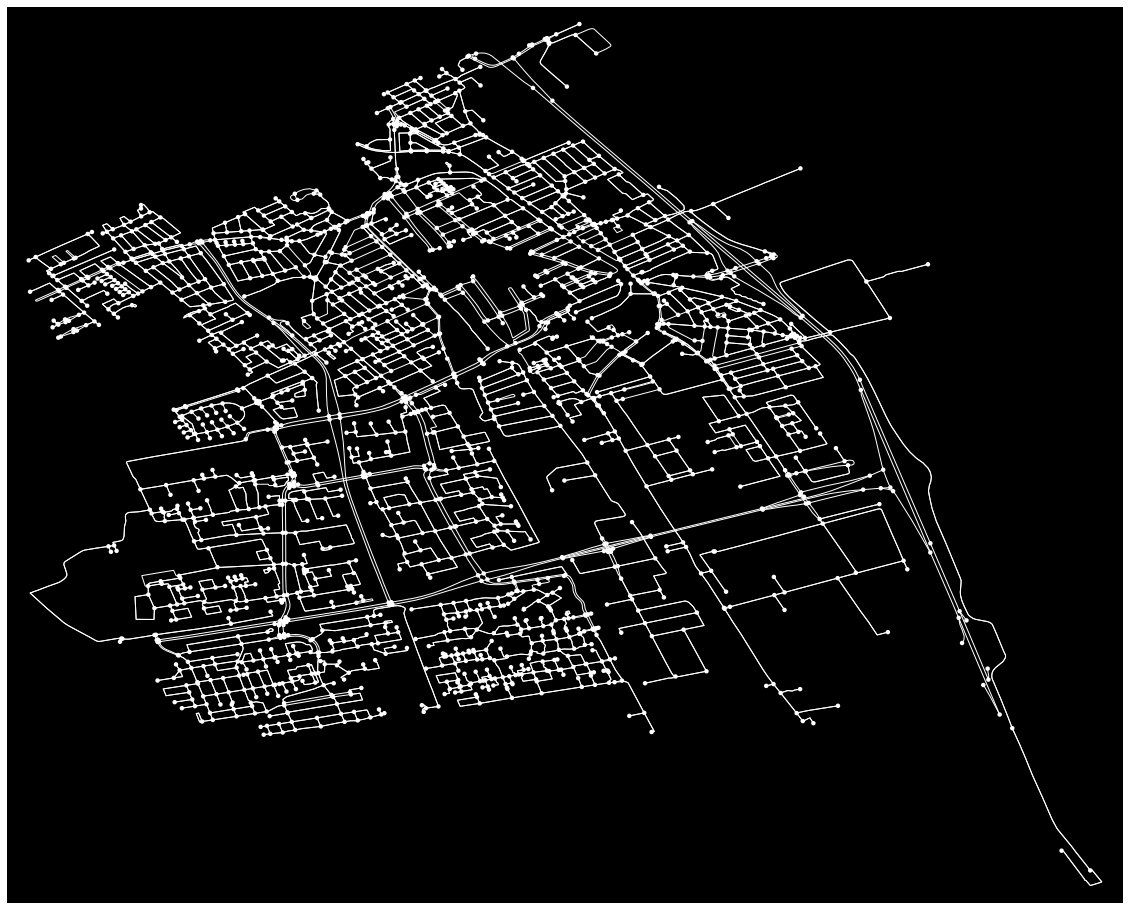

In [6]:
#No need to run
G = sim.inData.G
fig, ax = ox.plot_graph(G, figsize=(20, 20), show=False, close=False, node_size=20, bgcolor='black', edge_color='w')

Number of centeral nodes:  464


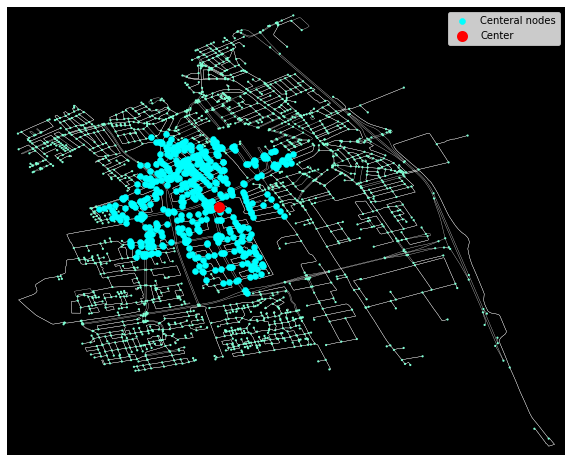

In [7]:
#No need to run
centeral_nodes = sim.inData.stats.central_nodes

l_x=[]
l_y=[]

for i in centeral_nodes:
    l_x.append(sim.inData.G.nodes[i]['x'])
    l_y.append(sim.inData.G.nodes[i]['y'])

print('Number of centeral nodes: ', len(l_x))

fig, ax = ox.plot_graph(sim.inData.G, figsize=(10, 10), node_size=5, edge_linewidth=0.3,
                            show=False, close=False, node_color='aquamarine',
                            edge_color='white', bgcolor='black')

scat = plt.scatter(x=l_x, y=l_y,c='aqua',linewidths=0.5, label='Centeral nodes')
#scat = plt.scatter(x=l_x, y=l_y,c='tab:red',linewidths=1)
scat = plt.scatter(x=sim.inData.G.nodes[sim.inData.stats.center]['x'], 
                   y=sim.inData.G.nodes[sim.inData.stats.center]['y'],c='red',linewidths=5,
                   label='Center')

plt.legend()

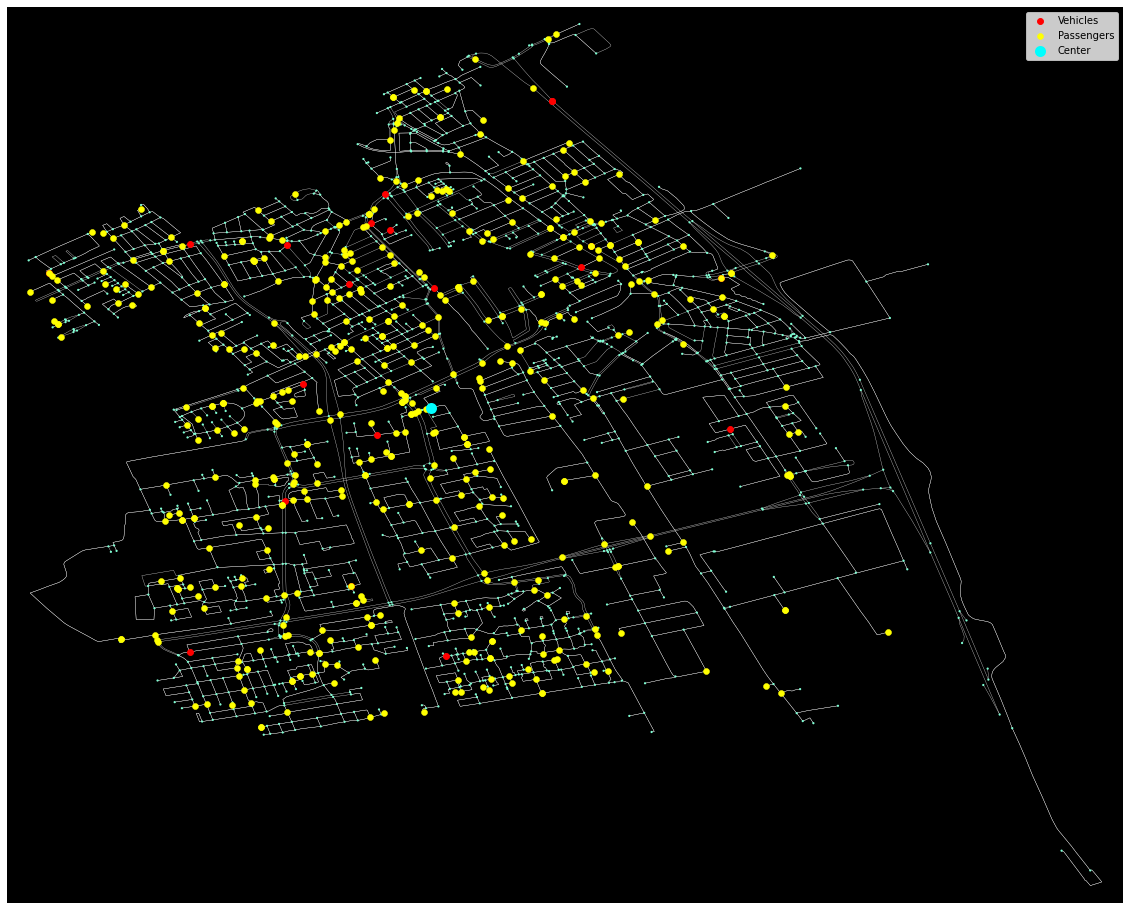

In [8]:
vehicles_position = sim.vehicle_fixed_positions
veh_lx=[]
veh_ly=[]
for i in vehicles_position:
    veh_lx.append(sim.inData.G.nodes[i]['x'])
    veh_ly.append(sim.inData.G.nodes[i]['y'])
    
passengers_position = sim.inData.passengers.pos
pass_lx=[]
pass_ly=[]
for i in passengers_position:
    pass_lx.append(sim.inData.G.nodes[i]['x'])
    pass_ly.append(sim.inData.G.nodes[i]['y'])

fig, ax = ox.plot_graph(sim.inData.G, figsize=(20, 20), node_size=5, edge_linewidth=0.3,
                            show=False, close=False, node_color='aquamarine',
                            edge_color='white', bgcolor='black')

scat = plt.scatter(x=veh_lx, y=veh_ly,c='red',linewidths=0.9, label='Vehicles')
scat = plt.scatter(x=pass_lx, y=pass_ly,c='yellow',linewidths=0.5, label='Passengers')
#scat = plt.scatter(x=l_x, y=l_y,c='tab:red',linewidths=1)
scat = plt.scatter(x=sim.inData.G.nodes[sim.inData.stats.center]['x'], 
                   y=sim.inData.G.nodes[sim.inData.stats.center]['y'],c='aqua',linewidths=5,
                   label='Center')


plt.legend()

In [9]:
r_def= ResultS(sim)

In [7]:
r_def.passengers['waiting_t[sec]'].mean()

224.026

In [8]:
import numpy as np
import pandas as pd
import math
import random as random
from dotmap import DotMap


def f_decline(veh, **kwargs):
    

    df = pd.DataFrame(veh.myrides)
    ASC = 1.5                                                                                   #ASC
    
    working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
    T1 = int(working_shift/3)
    request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']
    
    if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
        Time1 = 1
    else:
        Time1 = 0
        
    if veh.veh['pos'] in sim.inData.stats.central_nodes:
        loc = 1
    else:
        loc = 0
        
        
    d = veh.offers[0]['request']["origin"]                                                       #pickup_time
    o = veh.veh.pos
    pickup_time = veh.sim.skims.ride[o][d]/60  #minutes
      
    t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time
    
    if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
        t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
    else:
        t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
    waiting_time = (t - t0)/60 #minutes 
    
    surge_price = 0                                                                               #surge_price
    
    req = 1                         #req                                                          #req_long_rate_dec
    
    if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
        long = 1
    else:
        long = 0
        
    rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate
    
    if len(veh.declines.index) == 0:          #dec
        last_declined = 'False'
    else:
        last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']
        
    if last_declined == 'True':
        dec = 1
    else:
        dec = 0
        
           
    V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
        ((req*long*rate*dec)*0.0909) + (surge_price*0.099))
    
    
    acc_prob = (math.exp(V))/(1+math.exp(V))

    ran =  random.uniform(0, 1)
    if acc_prob > ran:
        a = 'Accepted'
    else:
        a = 'Rejected'
    attr = pd.DataFrame({'pax_id':[veh.offers[0]['pax_id']], 'veh_id':[veh.id], 'Time1':[Time1],  
                         'loc':[loc], 'Time1_loc':[Time1*loc], 'pickup_time':[pickup_time],
                         'waiting_t':[waiting_time], 'surge_price':[surge_price], 'req':1, 'long':long,
                         'rate':rate, 'dec':dec, 'req_long_rate_dec':[req*long*rate*dec*0.091], 
                         'request':a, 'P':[acc_prob]})
    sim.acceptance_attributes = pd.concat([sim.acceptance_attributes,attr])

    
    if acc_prob > ran:
        return False
    else:
        return True
    


sim.make_and_run(f_driver_decline=f_decline)

14-12-21 10:02:33-WARNING-pax    0  got rejected by vehicle 1                2021-12-14 07:33:33
14-12-21 10:02:33-WARNING-Nobody likes each other, Qs 1veh; 1req; tabu 2
14-12-21 10:02:33-WARNING-pax    2  got rejected by vehicle 3                2021-12-14 07:34:28
14-12-21 10:02:33-WARNING-pax    4  got rejected by vehicle 13               2021-12-14 07:35:12
14-12-21 10:02:34-WARNING-pax   18  got rejected by vehicle 20               2021-12-14 07:41:40
14-12-21 10:02:34-WARNING-pax   20  got rejected by vehicle 6                2021-12-14 07:42:43
14-12-21 10:02:34-WARNING-pax   21  got rejected by vehicle 11               2021-12-14 07:43:37
14-12-21 10:02:34-WARNING-pax   21  got rejected by vehicle 7                2021-12-14 07:43:37
14-12-21 10:02:34-WARNING-pax   25  got rejected by vehicle 3                2021-12-14 07:47:29
14-12-21 10:02:34-WARNING-pax   25  got rejected by vehicle 10               2021-12-14 07:47:29
14-12-21 10:02:34-WARNING-pax   25  got rejected by ve

In [9]:
r_homo= ResultS(sim)
resX = ResultS(sim)

In [10]:
r_homo.passengers.mean()['waiting_t[sec]']

217.42

In [11]:
df = r_homo.requests
df['z'] = df['n_of_requests']*df['acceptance_rate %']
ave_p = df['z'].sum()/df['n_of_requests'].sum()/100
ave_p

0.7526395173453997

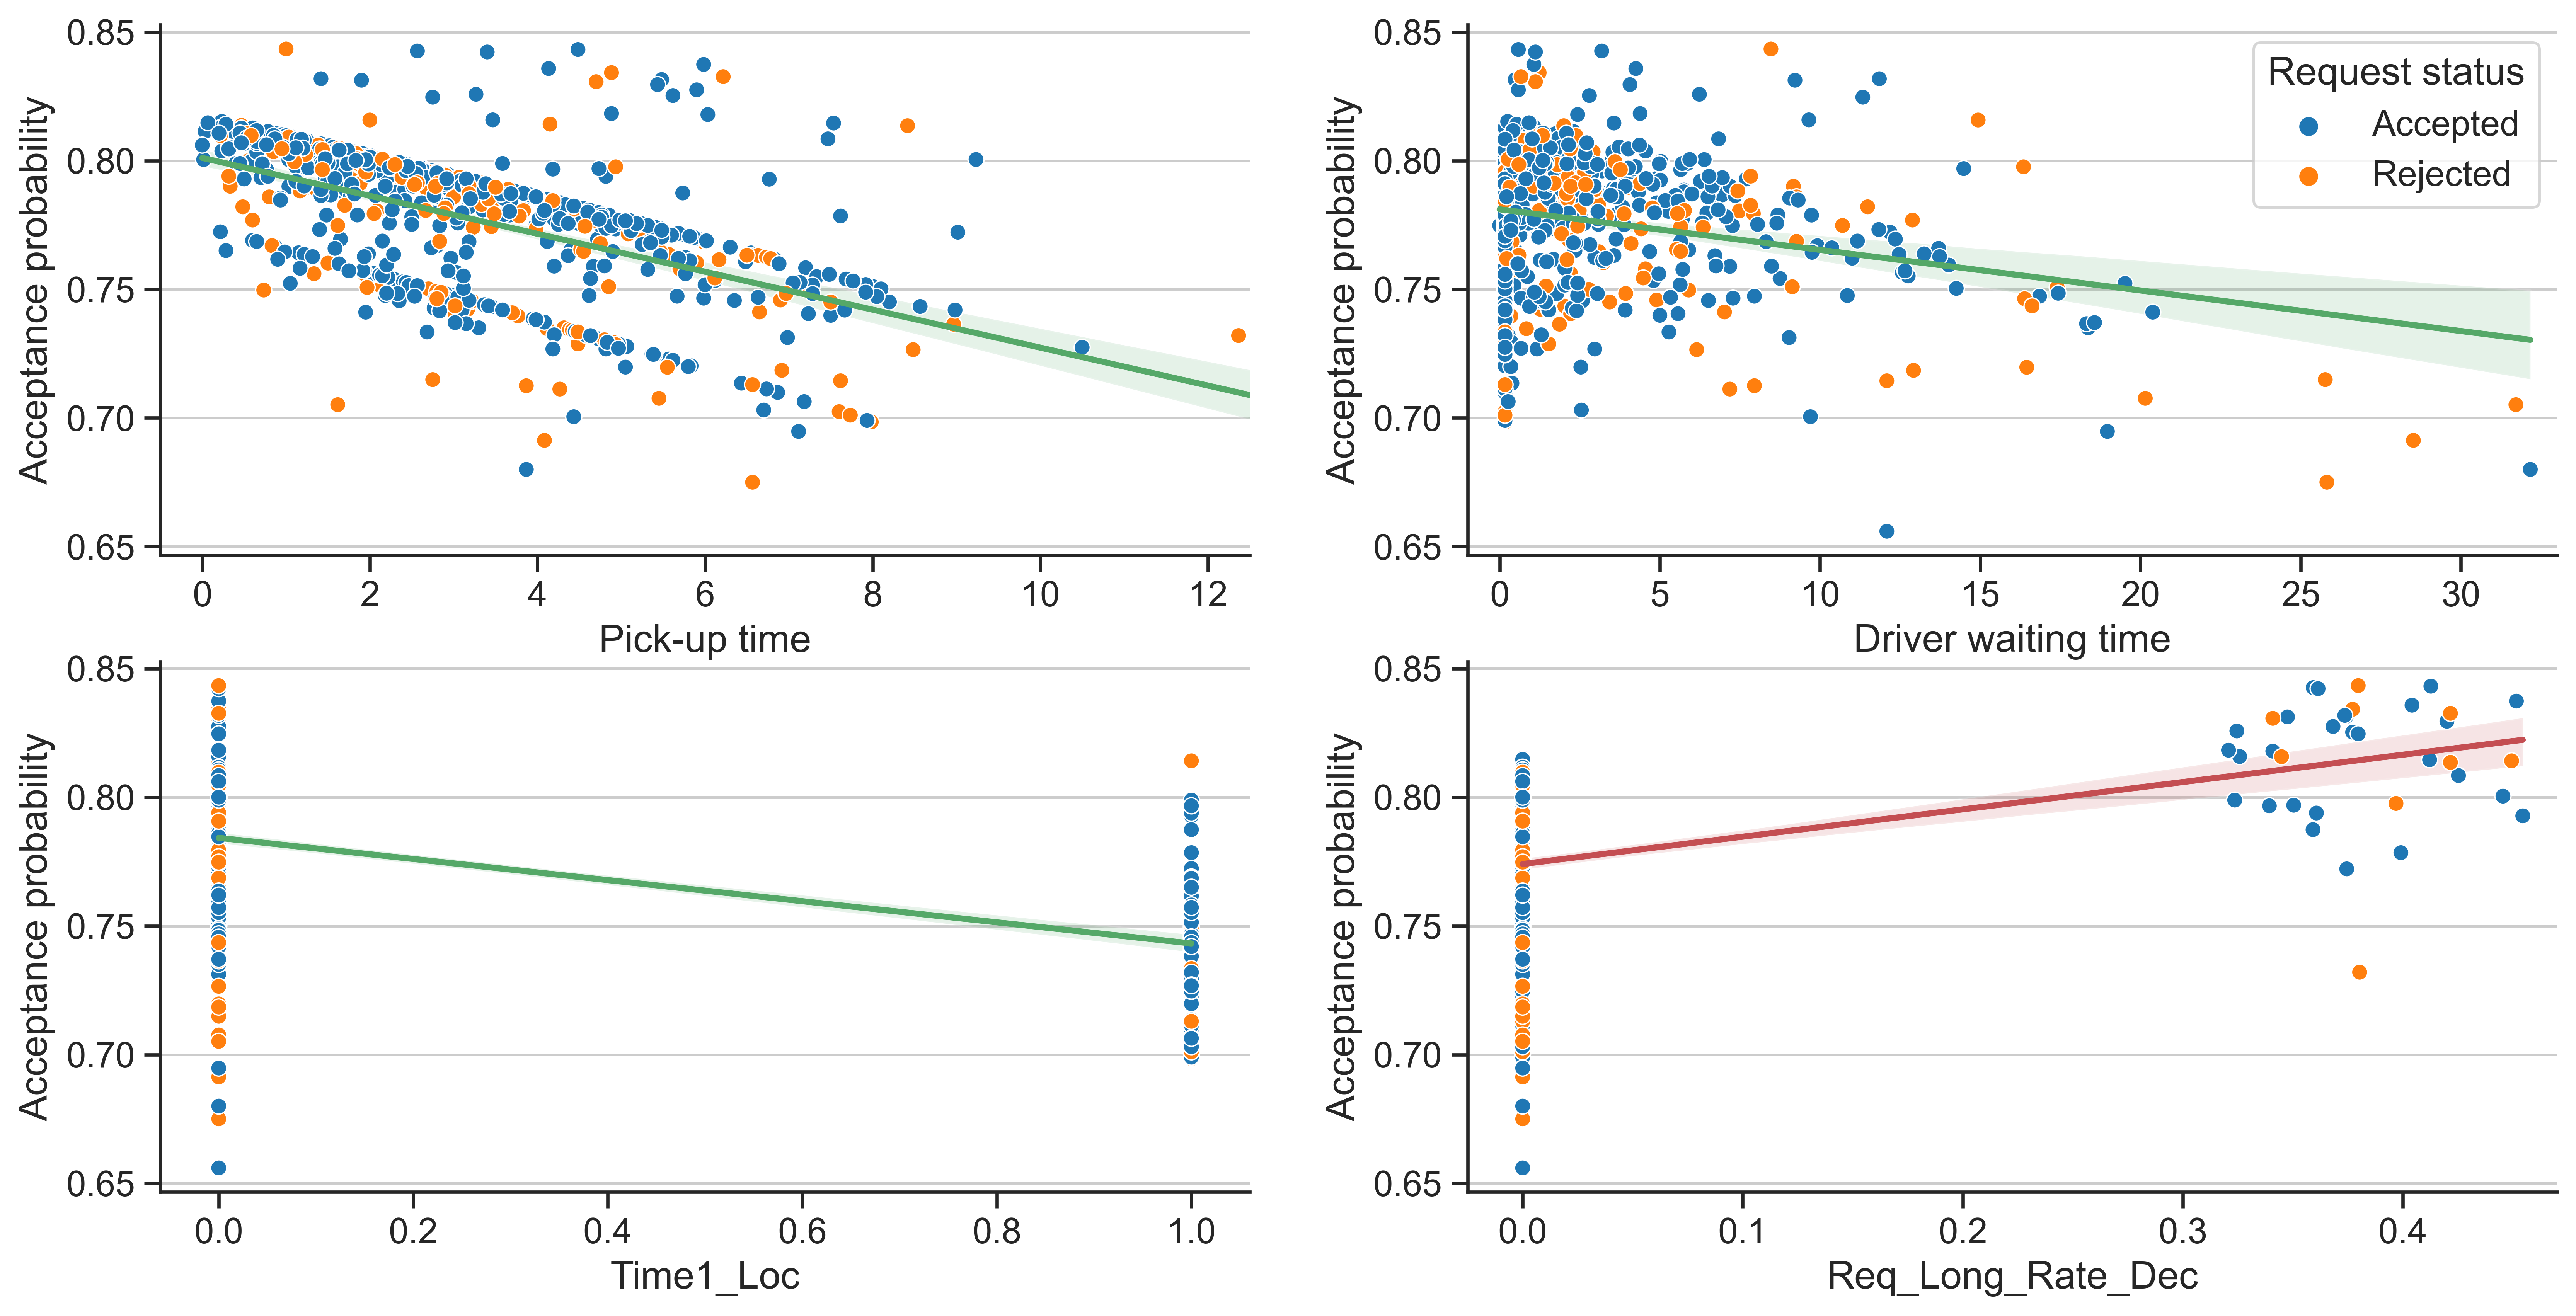

In [30]:
att = sim.acceptance_attributes
att = att[att['Pick-up time']<20]
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(font_scale = 1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,8))
sns.set_palette('tab10')
sns.despine()

ax[0,0].grid(axis='y')
sns.regplot(x=att['Pick-up time'], y=att['Acceptance probability'], ax= ax[0,0], scatter = False, color='g')
a = sns.scatterplot(x='Pick-up time', y='Acceptance probability', data=att, hue='Request status', ax= ax[0,0], legend=False)
a.set_xlim(-0.5,12.5)

ax[0,1].grid(axis='y')
sns.regplot(x=att['Driver waiting time'], y=att['Acceptance probability'], ax= ax[0,1], scatter = False, color='g')
b = sns.scatterplot(x='Driver waiting time', y='Acceptance probability', data=att, hue='Request status', ax= ax[0,1])
b.set_xlim(-1,33)

ax[1,0].grid(axis='y')
sns.regplot(x=att['Time1_Loc'], y=att['Acceptance probability'], ax= ax[1,0], scatter = False, color='g')
c = sns.scatterplot(x='Time1_Loc', y='Acceptance probability', data=att, hue='Request status', ax= ax[1,0], legend=False)
c.set_xlim(-0.06,1.06)

ax[1,1].grid(axis='y')
sns.regplot(x=att['Req_Long_Rate_Dec'], y=att['Acceptance probability'], color='r', ax= ax[1,1], scatter = False)
d = sns.scatterplot(x='Req_Long_Rate_Dec', y='Acceptance probability', data=att, hue='Request status', ax= ax[1,1], legend=False)
d.set_xlim(-0.025,0.47)

plt.savefig("Figure1.png")

In [20]:
r_homo.passengers

pax_id  veh_id  waiting_t[sec]  number of declines
0         0     1.0             410                   0
1         1     5.0             141                   0
2         2     3.0             138                   0
3         3    15.0              57                   0
4         4    14.0              68                   0
..      ...     ...             ...                 ...
495     495    13.0              75                   0
496     496    17.0             411                   1
497     497     5.0              77                   0
498     498    18.0             188                   1
499     499     2.0             146                   0

[500 rows x 4 columns]

In [311]:
df = r_homo.passengers
df['reject_t'] = df['number of declines']*10
df['waiting_t[sec]'] = df['waiting_t[sec]'] + df['reject_t']
df

pax_id  veh_id  waiting_t[sec]  number of declines  reject_t
0         0     2.0             446                   1        10
1         1    10.0              55                   0         0
2         2     4.0             113                   1        10
3         3    11.0             114                   0         0
4         4     7.0             176                   1        10
..      ...     ...             ...                 ...       ...
495     495    16.0             351                   0         0
496     496     5.0             242                   0         0
497     497    17.0             253                   0         0
498     498    14.0             447                   0         0
499     499    10.0              39                   0         0

[500 rows x 5 columns]

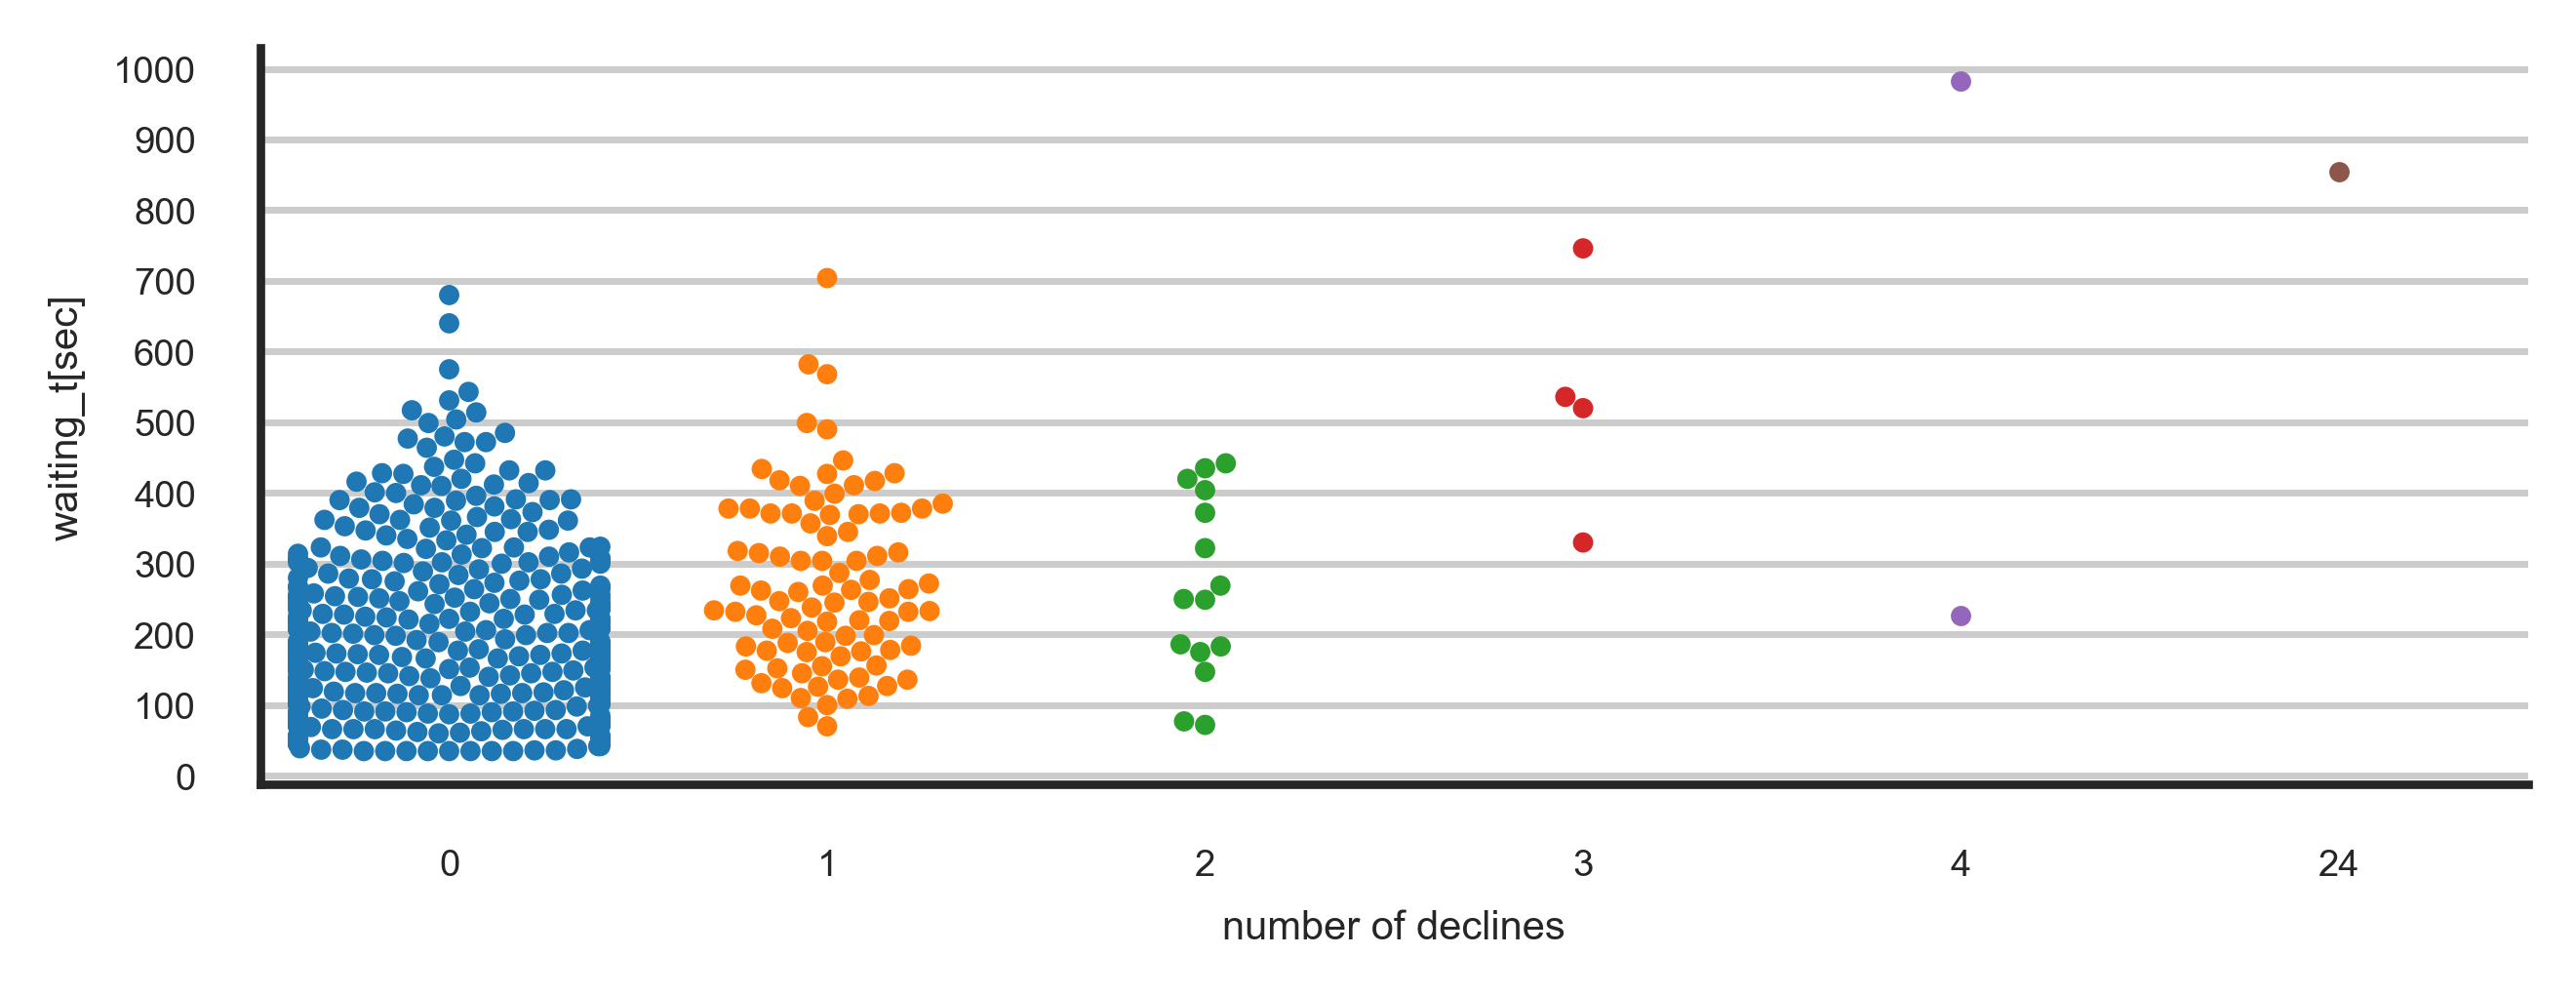

In [334]:
sns.set(rc={"figure.dpi":500, "savefig.dpi":500})
sns.set(font_scale = 0.5)
sns.set_palette('tab10')
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6,2))
sns.despine()

sns.swarmplot(x='number of declines', y='waiting_t[sec]', data=df, size=3)
plt.yticks([i for i in np.arange(0,1100,100)]) 
ax.grid(axis='y')

In [163]:
df.columns

Index(['pax_id', 'veh_id', 'waiting_t[sec]', 'number of declines', 'reject_t'], dtype='object')

In [124]:
a = 5
x = a
x = 6
a
why!!
df = r_homo.passengers
df['reject_t'] = df['number of declines']*10
df['waiting_t[sec]'] = df['waiting_t[sec]'] + df['reject_t']
df

5

In [12]:
d_results = {}

for i in range(1,11):
    
    for p in range(0,110,10):
        
        def f_decline(veh, **kwargs):
    
            if veh.id > 20*p/100: #(sim.params.nV/2):
            #if veh.id < (sim.params.nV/2)+1:
                if random.uniform(0, 1) > ave_p:
                    return True
                else:
                    return False
            else:
                df = pd.DataFrame(veh.myrides)
                ASC = 1.5                                                                                  #ASC

                working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
                T1 = int(working_shift/3)
                request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']

                if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
                    Time1 = 1
                else:
                    Time1 = 0

                if veh.veh['pos'] in sim.inData.stats.central_nodes:
                    loc = 1
                else:
                    loc = 0


                d = veh.offers[0]['request']["origin"]                                                       #pickup_time
                o = veh.veh.pos
                pickup_time = veh.sim.skims.ride[o][d]/60  #minutes

                t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time

                if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
                    t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
                else:
                    t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
                waiting_time = (t - t0)/60 #minutes 

                surge_price = 0                                                                               #surge_price

                req = 1                         #req                                                          #req_long_rate_dec

                if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
                    long = 1
                else:
                    long = 0

                rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate

                if len(veh.declines.index) == 0:          #dec
                    last_declined = 'False'
                else:
                    last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']

                if last_declined == 'True':
                    dec = 1
                else:
                    dec = 0


                V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
                    ((req*long*rate*dec)*0.0909) + (surge_price*0.099))


                acc_prob = (math.exp(V))/(1+math.exp(V))

                if acc_prob > random.uniform(0, 1):
                    return False
                else:
                    return True
        
        sim.make_and_run(f_driver_decline=f_decline)
        res= ResultS(sim)
        d_results["sim{sim_n}p{percentage}".format(sim_n=i, percentage=p)] = res


14-12-21 10:06:09-WARNING-pax    0  got rejected by vehicle 1                2021-12-14 07:33:33
14-12-21 10:06:09-WARNING-Nobody likes each other, Qs 1veh; 1req; tabu 2
14-12-21 10:06:09-WARNING-pax    0  got rejected by vehicle 2                2021-12-14 07:33:33
14-12-21 10:06:09-WARNING-Nobody likes each other, Qs 2veh; 1req; tabu 3
14-12-21 10:06:09-WARNING-pax    1  got rejected by vehicle 10               2021-12-14 07:34:27
14-12-21 10:06:09-WARNING-pax    1  got rejected by vehicle 11               2021-12-14 07:34:27
14-12-21 10:06:09-WARNING-pax    4  got rejected by vehicle 13               2021-12-14 07:35:12
14-12-21 10:06:09-WARNING-pax    4  got rejected by vehicle 7                2021-12-14 07:35:12
14-12-21 10:06:09-WARNING-pax    5  got rejected by vehicle 15               2021-12-14 07:35:51
14-12-21 10:06:09-WARNING-pax    8  got rejected by vehicle 15               2021-12-14 07:36:19
14-12-21 10:06:09-WARNING-pax    8  got rejected by vehicle 12               2

In [13]:
d_results['sim3p100'].passengers['waiting_t[sec]'].mean()

215.814

In [122]:
dx = {}
da = {}
for i in range(1,11):
    d_x = {}
    d_a = {}
    for p in range(0,110,10):
        r = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].trips.groupby(['veh_id']).sum()
        
        rx = r.iloc[0:int(p/100*params.nV)]
        mx = rx['revenue $'].mean()
        d_x["{} %".format(p)] = mx
        
        ra = r.iloc[int(p/100*params.nV):int(params.nV)]
        ma = ra['revenue $'].mean()
        d_a["{} %".format(100-p)] = ma

    dx["sim{}".format(i)] = d_x
    da["sim{}".format(i)] = d_a

In [123]:
# variation in the revenue of drivers who are employing the acceptance function

xr = pd.DataFrame(dx)
#xr['mean'] = xr.mean(axis=1)
xr

sim1        sim2        sim3        sim4        sim5        sim6  \
0 %           NaN         NaN         NaN         NaN         NaN         NaN   
10 %   151.460000  147.560000  142.350000  151.270000  148.090000  152.670000   
20 %   150.390000  147.460000  150.835000  149.390000  144.585000  145.590000   
30 %   150.503333  145.876667  150.686667  145.643333  151.766667  143.756667   
40 %   146.815000  147.425000  147.732500  149.307500  150.222500  149.842500   
50 %   152.062000  154.662000  152.566000  149.468000  146.286000  151.884000   
60 %   151.946667  150.455000  149.736667  147.746667  149.725000  147.228333   
70 %   151.011429  148.750000  147.037143  150.228571  151.261429  149.111429   
80 %   148.870000  149.706250  148.766250  149.416250  149.115000  149.938750   
90 %   147.858889  148.488889  148.555556  147.735556  148.127778  149.021111   
100 %  144.093000  144.093000  144.093000  144.093000  144.093000  144.093000   

             sim7        sim8        sim9       sim10  
0 %           NaN         NaN         NaN         NaN  
10 %   145.040000  147.410000  160.340000  140.930000  
20 %   149.765000  156.370000  149.225000  153.155000  
30 %   152.986667  147.543333  146.876667  147.293333  
40 %   151.202500  147.720000  147.762500  150.735000  
50 %   151.120000  149.184000  147.986000  148.654000  
60 %   150.855000  148.496667  145.475000  152.766667  
70 %   149.842857  150.315714  148.790000  149.080000  
80 %   150.786250  149.161250  148.486250  149.447500  
90 %   147.970000  147.910000  147.544444  147.916667  
100 %  144.093000  144.093000  144.093000  144.093000

In [124]:
# variation in the revenue of drivers who are not employing the acceptance function

ar = pd.DataFrame(da)
#ar['mean'] = ar.mean(axis=1)
ar

sim1        sim2        sim3        sim4        sim5        sim6  \
100 %  144.487000  144.487000  144.487000  144.487000  144.487000  144.487000   
90 %   143.712222  144.145556  144.724444  143.733333  144.086667  143.577778   
80 %   143.011250  143.743750  142.900000  143.261250  144.462500  143.648750   
70 %   141.908571  143.248571  141.830000  143.991429  141.367143  144.800000   
60 %   142.935000  142.528333  142.323333  141.273333  140.663333  140.916667   
50 %   136.912000  134.312000  136.408000  139.506000  142.688000  137.090000   
40 %   133.297500  135.535000  136.612500  139.597500  136.630000  140.375000   
30 %   129.263333  134.540000  138.536667  131.090000  128.680000  133.696667   
20 %   126.955000  123.610000  127.370000  124.770000  125.975000  122.680000   
10 %   114.140000  108.470000  107.870000  115.250000  111.720000  103.680000   
0 %           NaN         NaN         NaN         NaN         NaN         NaN   

             sim7        sim8        sim9       sim10  
100 %  144.487000  144.487000  144.487000  144.487000  
90 %   144.425556  144.162222  142.284444  144.882222  
80 %   143.167500  141.516250  143.302500  142.320000  
70 %   140.844286  143.177143  143.462857  143.284286  
60 %   140.010000  142.331667  142.303333  140.321667  
50 %   137.854000  139.790000  140.988000  140.320000  
40 %   134.935000  138.472500  142.050000  132.067500  
30 %   131.990000  130.886667  134.446667  133.770000  
20 %   119.290000  125.790000  128.490000  124.645000  
10 %   113.140000  113.680000  116.970000  113.620000  
0 %           NaN         NaN         NaN         NaN

In [125]:
# since we thr trip fare is based on trip distance(oringin to destination) and it does not include pickup
# distance, the total trip fare is almost same for all 110 simulation. If I want this to change I need to 
# add pick time and base fare maybe.

tr = {}

for i in range(1,11):
    d = {}
    for p in range(0,110,10):
        e = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].trips.groupby(['veh_id']).sum()['revenue $'].mean()
        d["{} %".format(p)] = e
        
    tr["sim{}".format(i)] = d

tr = pd.DataFrame(tr)
tr['mean'] = tr.mean(axis=1)
tr['percentage'] = [i for i in np.arange(0,110,10)]
tr

sim1     sim2     sim3     sim4     sim5     sim6     sim7     sim8  \
0 %    144.487  144.487  144.487  144.487  144.487  144.487  144.487  144.487   
10 %   144.487  144.487  144.487  144.487  144.487  144.487  144.487  144.487   
20 %   144.487  144.487  144.487  144.487  144.487  144.037  144.487  144.487   
30 %   144.487  144.037  144.487  144.487  144.487  144.487  144.487  144.487   
40 %   144.487  144.487  144.487  144.487  144.487  144.487  144.487  144.487   
50 %   144.487  144.487  144.487  144.487  144.487  144.487  144.487  144.487   
60 %   144.487  144.487  144.487  144.487  144.487  144.487  144.487  144.487   
70 %   144.487  144.487  144.487  144.487  144.487  144.487  144.487  144.487   
80 %   144.487  144.487  144.487  144.487  144.487  144.487  144.487  144.487   
90 %   144.487  144.487  144.487  144.487  144.487  144.487  144.487  144.487   
100 %  144.093  144.093  144.093  144.093  144.093  144.093  144.093  144.093   

          sim9    sim10      mean  percentage  
0 %    144.487  144.487  144.4870           0  
10 %   144.090  144.487  144.4473          10  
20 %   144.487  144.487  144.4420          20  
30 %   144.487  144.487  144.4420          30  
40 %   144.487  144.487  144.4870          40  
50 %   144.487  144.487  144.4870          50  
60 %   144.105  144.487  144.4488          60  
70 %   144.487  144.487  144.4870          70  
80 %   144.487  144.487  144.4870          80  
90 %   144.487  144.487  144.4870          90  
100 %  144.093  144.093  144.0930         100

In [126]:
l = []
for p in range(0,110,10):
    for i in range(1,11):
        l.append(p)
        
ar = ar.T
xr = xr.T
        
colsa = [ar[col].squeeze() for col in ar]
colsx = [xr[col].squeeze() for col in xr]

anr = pd.concat(colsa, ignore_index=True)
xnr = pd.concat(colsx, ignore_index=True)

anr = anr.to_frame()
anr = anr.rename(columns = {0:'Driver income [€]'})
anr['Percentage of rational drivers [%]'] = l

xnr = xnr.to_frame()
xnr = xnr.rename(columns = {0:'Driver income [€]'})
xnr['Percentage of rational drivers [%]'] = l

In [127]:
dx = {}
da = {}
for i in range(1,11):
    d_x = {}
    d_a = {}
    for p in range(0,110,10):
        r = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].passengers
        rx = r; ra = r
        
        rx = rx[rx['veh_id']>0]; rx = rx[rx['veh_id']<int(p/100*params.nV)+1]
        mx = rx['waiting_t[sec]'].mean()
        d_x["{} %".format(p)] = mx
        
        ra = ra[ra['veh_id']>int(p/100*params.nV)]; ra = ra[ra['veh_id']<int(params.nV)+1]
        ma = ra['waiting_t[sec]'].mean()
        d_a["{} %".format(100-p)] = ma

    dx["sim{}".format(i)] = d_x
    da["sim{}".format(i)] = d_a

In [128]:
# variation in the waiting time of passenger who are being assigned to the drivers employing acceptance function

xw = pd.DataFrame(dx)
#xw['mean'] = xw.mean(axis=1)
xw

sim1        sim2        sim3        sim4        sim5        sim6  \
0 %           NaN         NaN         NaN         NaN         NaN         NaN   
10 %   275.607843  224.245614  265.820000  266.122449  237.462963  268.086957   
20 %   210.935780  225.153846  268.166667  235.271739  231.190000  219.038095   
30 %   216.740741  236.253247  246.476821  250.374194  236.900662  229.484663   
40 %   208.595238  216.859155  208.291866  232.939815  249.756219  244.866029   
50 %   239.819549  230.697674  239.046154  234.915709  236.348485  213.775665   
60 %   234.726415  231.852941  238.923077  238.107492  233.575563  243.495017   
70 %   230.929730  236.196133  224.106557  235.519022  235.101648  239.521008   
80 %   238.226829  207.771635  229.390361  242.271845  223.125301  241.743341   
90 %   231.609071  224.850000  221.919214  236.326180  231.255914  235.825431   
100 %  223.470942  213.871743  215.014028  217.132265  224.907816  227.486974   

             sim7        sim8        sim9       sim10  
0 %           NaN         NaN         NaN         NaN  
10 %   236.150943  255.538462  245.788462  258.044444  
20 %   228.909910  244.745098  253.186275  219.576923  
30 %   230.571429  224.455696  244.535032  215.625767  
40 %   218.507246  227.839806  231.514563  248.937500  
50 %   232.797619  239.384906  231.352941  224.100000  
60 %   227.381410  243.809211  232.929766  235.923567  
70 %   233.333333  216.297521  244.002740  231.616022  
80 %   222.657831  233.140811  223.619855  237.621359  
90 %   238.625541  222.982721  226.924242  226.428571  
100 %  220.380762  213.412826  221.747495  216.136273

In [129]:
# variation in the waiting time of passenger who are being assigned to driver who are not employing 
# the acceptance function

aw = pd.DataFrame(da)
#aw['mean'] = aw.mean(axis=1)
aw

sim1        sim2        sim3        sim4        sim5        sim6  \
100 %  259.078000  263.468000  249.690000  256.576000  254.934000  248.052000   
90 %   266.481069  254.564334  259.053333  258.130820  252.813901  249.317181   
80 %   255.066496  265.020202  262.608040  248.970588  257.922500  263.829949   
70 %   265.399408  270.985507  264.297994  253.521739  267.893983  262.872404   
60 %   269.844828  264.703833  263.498282  278.309859  261.872910  273.951890   
50 %   284.324786  282.268595  286.345833  278.129707  279.894068  279.485232   
40 %   312.412088  282.515464  291.159574  286.544041  277.878307  284.281407   
30 %   306.838462  314.311594  306.985075  315.727273  310.213235  289.104895   
20 %   339.222222  367.285714  338.717647  338.988636  343.435294  340.367816   
10 %   496.729730  440.925000  425.809524  522.676471  500.400000  501.222222   
0 %           NaN         NaN         NaN         NaN         NaN         NaN   

             sim7        sim8        sim9       sim10  
100 %  268.484000  246.894000  252.936000  245.510000  
90 %   255.856823  261.247768  259.035794  249.531868  
80 %   271.030848  249.610553  260.708543  250.315657  
70 %   267.469027  264.362573  275.501458  263.899110  
60 %   266.761092  270.248299  265.547619  282.647260  
50 %   277.362903  288.157447  271.979592  273.662500  
40 %   289.053191  282.510204  279.520000  302.510753  
30 %   315.528571  297.751825  313.496296  303.224638  
20 %   345.905882  350.592593  338.908046  345.920455  
10 %   479.500000  517.432432  481.605263  470.578947  
0 %           NaN         NaN         NaN         NaN

In [68]:
tw = {}

for i in range(1,11):
    d = {}
    for p in range(0,110,10):
        e = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].passengers['waiting_t[sec]'].mean()
        d["{} %".format(p)] = e
        
    tw["sim{}".format(i)] = d
# Considering the p=0 (no driver is employing acceptance model) & p=100 (all drivers are employing 
# acceptance model) states we can see in general the acceptance function has a positive effect on 
# passengers waiting time. Indeed, the acceptance function is reducing the waiting time when all drivers are
# employing it. Of course it is not pruducing lower waiting times comparing to the state in which all
# driver are accepting all requests.

tw = pd.DataFrame(tw)
tw['mean'] = tw.mean(axis=1)
tw['percentage'] = [i for i in np.arange(0,110,10)]
tw

sim1     sim2     sim3     sim4     sim5     sim6     sim7     sim8  \
0 %    259.078  263.468  249.690  256.576  254.934  248.052  268.484  246.894   
10 %   267.412  251.108  259.730  258.914  251.156  251.044  253.768  260.654   
20 %   245.446  256.728  263.742  246.450  252.576  255.126  261.680  248.618   
30 %   249.634  260.976  258.916  252.546  258.534  251.988  255.588  251.752   
40 %   244.120  244.322  240.422  258.710  257.002  261.794  246.784  252.776   
50 %   260.648  255.658  261.750  255.572  256.902  244.922  254.902  262.308   
60 %   263.004  251.510  258.564  256.804  250.322  259.728  250.570  258.980   
70 %   250.666  257.756  246.318  256.694  255.532  253.702  256.348  238.616   
80 %   256.406  234.570  247.976  259.294  243.578  258.904  243.610  252.168   
90 %   251.228  242.136  239.046  255.798  250.096  254.934  256.932  244.772   
100 %  224.254  214.674  215.814  217.928  225.688  228.262  221.170  214.216   

          sim9    sim10      mean  percentage  
0 %    252.936  245.510  254.5622           0  
10 %   258.370  250.298  256.2454          10  
20 %   259.174  243.922  253.3462          20  
30 %   265.778  248.162  255.3874          30  
40 %   251.526  268.624  252.6080          40  
50 %   251.260  247.890  255.1812          50  
60 %   252.330  260.694  256.2506          60  
70 %   262.766  251.380  252.9778          70  
80 %   243.680  256.682  249.6868          80  
90 %   246.280  244.984  248.6206          90  
100 %  222.534  216.934  220.1474         100

In [130]:
aw = aw.T
xw = xw.T

colsa = [aw[col].squeeze() for col in aw]
colsx = [xw[col].squeeze() for col in xw]

anw = pd.concat(colsa, ignore_index=True)
xnw = pd.concat(colsx, ignore_index=True)

anw = anw.to_frame()
anw = anw.rename(columns = {0:'Traveller waiting time [sec]'})
anw['Percentage of rational drivers [%]'] = l

xnw = xnw.to_frame()
xnw = xnw.rename(columns = {0:'Traveller waiting time [sec]'})
xnw['Percentage of rational drivers [%]'] = l

In [98]:
dx = {}
da = {}
for i in range(1,11):
    d_x = {}
    d_a = {}
    for p in range(0,110,10):
        r = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].trips.groupby(['veh_id']).mean()
        
        rx = r.iloc[0:int(p/100*params.nV)]
        mx = rx['veh_waiting_t[sec]'].mean()
        d_x["{} %".format(p)] = mx
        
        ra = r.iloc[int(p/100*params.nV):int(params.nV)]
        ma = ra['veh_waiting_t[sec]'].mean()
        d_a["{} %".format(100-p)] = ma

    dx["sim{}".format(i)] = d_x
    da["sim{}".format(i)] = d_a

In [103]:
xdw = pd.DataFrame(dx)
xdw['mean'] = xdw.mean(axis=1)
xdw

sim1        sim2        sim3        sim4        sim5        sim6  \
0 %           NaN         NaN         NaN         NaN         NaN         NaN   
10 %   138.148148  132.344212  171.340000  142.256689  147.870370  187.045455   
20 %   159.246750  169.991953  124.827797  195.872858  188.885417  172.788683   
30 %   152.585191  168.842844  155.846325  156.488947  171.341940  157.595286   
40 %   177.135896  166.237107  181.540980  145.103437  156.725772  149.847490   
50 %   143.719221  157.167767  151.394846  152.949679  159.890146  172.386897   
60 %   148.614765  169.149081  157.875273  168.056256  163.461644  178.109224   
70 %   158.187981  164.948154  172.781987  153.739938  155.838557  158.896990   
80 %   161.252399  178.451670  166.283292  161.156861  169.688207  154.469285   
90 %   172.005400  175.186870  179.631940  162.535962  169.039364  161.695092   
100 %  190.165691  201.006425  194.985823  195.057342  189.724787  190.747140   

             sim7        sim8        sim9       sim10        mean  
0 %           NaN         NaN         NaN         NaN         NaN  
10 %   149.433048  135.454074  118.250000  221.270000  154.341200  
20 %   145.478389  150.345000  169.761726  159.672632  163.687120  
30 %   152.052468  174.681703  152.788989  177.257466  161.948116  
40 %   168.971195  175.741171  170.113492  147.549679  163.896622  
50 %   167.473698  149.973928  170.611525  167.084424  159.265213  
60 %   165.735080  167.818314  178.579904  147.755044  164.515458  
70 %   164.980498  171.841746  154.682325  165.674780  162.157296  
80 %   165.373755  160.687064  171.894697  162.010007  165.126724  
90 %   164.717575  177.759358  172.611959  174.263825  170.944735  
100 %  193.497290  200.584825  194.968417  195.984224  194.672196

In [104]:
adw = pd.DataFrame(da)
adw['mean'] = adw.mean(axis=1)
adw

sim1        sim2        sim3        sim4        sim5        sim6  \
100 %  161.146494  159.006376  174.320805  162.939446  164.895898  176.352816   
90 %   162.096746  172.971683  160.993153  167.537304  174.607105  167.878193   
80 %   177.401694  163.336464  167.201143  162.986537  162.269291  169.962141   
70 %   171.698844  171.383514  166.847622  178.714075  162.690371  172.377213   
60 %   166.352508  178.298618  173.154560  201.854132  173.457274  172.026003   
50 %   185.271970  173.631727  172.046977  179.316327  172.964947  171.385334   
40 %   188.026969  166.203786  172.960600  157.490774  171.670779  141.671296   
30 %   208.093651  165.003845  174.823804  254.167420  192.057758  196.952741   
20 %   179.892212  182.199301  192.552153  208.695061  190.292576  200.832517   
10 %   175.840741  156.568681  143.107407  185.577075  242.019231  205.705455   
0 %           NaN         NaN         NaN         NaN         NaN         NaN   

             sim7        sim8        sim9       sim10        mean  
100 %  159.608114  170.964761  171.355050  174.874663  167.546442  
90 %   168.734862  165.058557  167.432260  163.899313  167.120918  
80 %   169.982486  174.466531  165.114535  179.566577  169.228740  
70 %   175.001448  170.682082  164.737378  169.482590  170.361514  
60 %   164.611699  166.117542  174.073021  168.835231  173.878059  
50 %   166.375663  181.170082  164.247715  177.604965  174.401571  
40 %   178.530130  158.651496  153.804751  180.245455  166.925604  
30 %   168.103856  187.139946  183.355144  176.499453  190.619762  
20 %   234.604078  196.749289  182.806035  173.979833  194.260305  
10 %   165.080128  181.638889  135.050595  189.512821  178.010102  
0 %           NaN         NaN         NaN         NaN         NaN

In [101]:
adw = adw.T
xdw = xdw.T
        
colsa = [adw[col].squeeze() for col in adw]
colsx = [xdw[col].squeeze() for col in xdw]

a = pd.concat(colsa, ignore_index=True)
x = pd.concat(colsx, ignore_index=True)

a = a.to_frame()
a = a.rename(columns = {0:'driver_wait_t'})
a['p'] = l

x = x.to_frame()
x = x.rename(columns = {0:'driver_wait_t'})
x['p'] = l

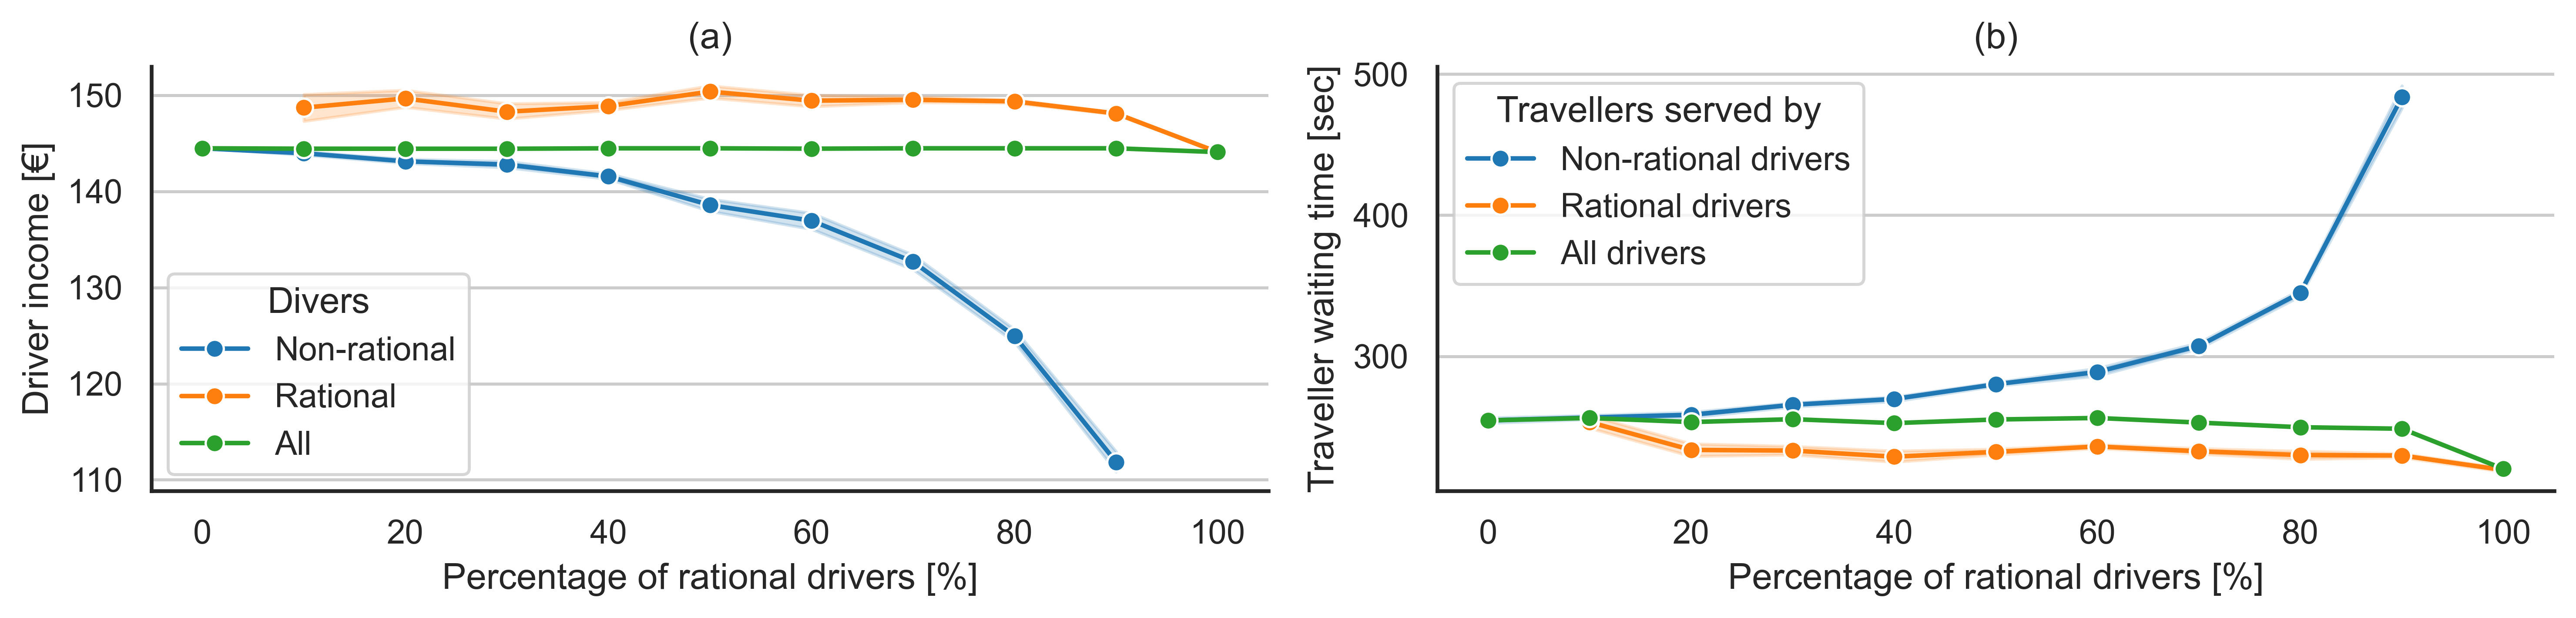

In [242]:
# I need to increase number of simulations to get a better diagram

sns.set(rc={"figure.dpi":500, "savefig.dpi":500})
sns.set(font_scale = 1)
sns.set_palette('tab10')
sns.set_style('white')
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,3))
sns.despine()

sns.lineplot(x='Percentage of rational drivers [%]', y='Driver income [€]', data=anr, marker='o', ci=60, ax=ax[0])
sns.lineplot(x='Percentage of rational drivers [%]', y='Driver income [€]', data=xnr, marker='o',ci=60, ax=ax[0])
sns.lineplot(x='percentage', y='mean', data=tr, marker='o', ax=ax[0])
ax[0].grid(axis='y')
ax[0].set_title('(a)')
ax[0].legend(title='Divers',labels=["Non-rational","Rational", "All"], loc=3)

sns.lineplot(x='Percentage of rational drivers [%]', y='Traveller waiting time [sec]', data=anw, marker='o', ci=60, ax=ax[1])
sns.lineplot(x='Percentage of rational drivers [%]', y='Traveller waiting time [sec]', data=xnw, marker='o',ci=60, ax=ax[1])
sns.lineplot(x='percentage', y='mean', data=tw, marker='o', ax=ax[1])
ax[1].grid(axis='y')
ax[1].set_title('(b)')
ax[1].legend(title='Travellers served by',labels=["Non-rational drivers","Rational drivers", "All drivers"], loc=2)


plt.tight_layout()
plt.savefig('Fig3.png')

In [198]:
gini = {}

for n in range(1,11):
    d = {}
    for p in range(0,110,10):
        g = list(d_results['sim{sim_n}p{percentage}'.format(sim_n=n, percentage=p)].trips.groupby(['veh_id']).sum()['revenue $'])
        g.sort()
        s = 0
        for i in range(1,21):
            a = g[i-1]*((20-i+1)+(20-i))/2
            s = s+a
        t = 20*np.sum(g)/2
        gi = (t-s)/t

        d["{} %".format(p)] = gi
        
    gini["sim{}".format(n)] = d


In [199]:
gini = pd.DataFrame(gini)
gini['mean'] = gini.mean(axis=1)
gini

sim1      sim2      sim3      sim4      sim5      sim6      sim7  \
0 %    0.067139  0.056896  0.064081  0.063372  0.054486  0.056630  0.062370   
10 %   0.053243  0.072634  0.066283  0.056432  0.046932  0.056423  0.055865   
20 %   0.081161  0.061630  0.056459  0.064532  0.071126  0.060690  0.061341   
30 %   0.049502  0.064226  0.069504  0.061353  0.070402  0.050298  0.073282   
40 %   0.054520  0.053513  0.064488  0.064085  0.070821  0.065417  0.065463   
50 %   0.069730  0.056160  0.070819  0.058391  0.058262  0.064080  0.054259   
60 %   0.050519  0.055272  0.056923  0.054461  0.060511  0.067015  0.054336   
70 %   0.049338  0.047733  0.071423  0.065310  0.060523  0.054766  0.052061   
80 %   0.063505  0.089550  0.063224  0.055177  0.066259  0.070962  0.065995   
90 %   0.069406  0.044526  0.057655  0.079233  0.067824  0.065583  0.065931   
100 %  0.047528  0.037287  0.052283  0.053476  0.045691  0.034385  0.034046   

           sim8      sim9     sim10      mean  
0 %    0.047714  0.056641  0.058605  0.058793  
10 %   0.053225  0.060171  0.053936  0.057514  
20 %   0.066726  0.063149  0.057805  0.064462  
30 %   0.051688  0.063707  0.069853  0.062381  
40 %   0.070640  0.061297  0.067015  0.063726  
50 %   0.058748  0.069605  0.067061  0.062712  
60 %   0.064118  0.062584  0.063806  0.058954  
70 %   0.061163  0.050222  0.067861  0.058040  
80 %   0.045184  0.060266  0.058957  0.063908  
90 %   0.076954  0.058352  0.067570  0.065303  
100 %  0.034491  0.048352  0.049752  0.043729

<AxesSubplot:xlabel='percentage', ylabel='mean'>

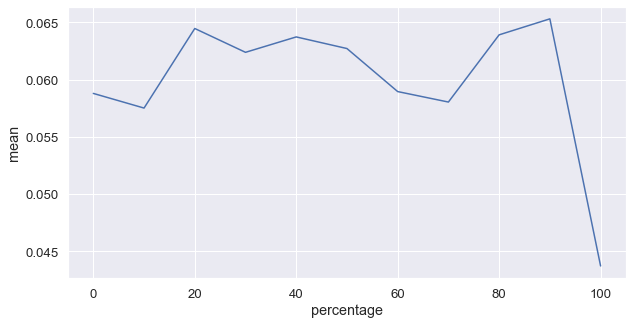

In [200]:
gini['percentage'] = [i for i in np.arange(0,110,10)]

fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x='percentage', y='mean', data=gini, ci=0)

In [8]:
d_def = {}
    
for i in range(1,2):
        
    def f_decline(veh, **kwargs):
        if True:
            return False
        else:
            return True
    sim.make_and_run(f_driver_decline=f_decline)
    resD= ResultS(sim)
    d_def["sim{sim_n}def".format(sim_n=i)] = resD
    
resD.passengers['waiting_t[sec]'].mean()

02-12-21 11:16:13-WARNING-simulation time 8.5 s
02-12-21 11:16:14-WARNING-assertion tests for simulation results - passed


201.968

In [28]:
d_ave_p = {}
    
for i in range(1,2):
        
    def f_decline(veh, **kwargs):
        if random.uniform(0, 1) > ave_p:
            return True
        else:
            return False
    sim.make_and_run(f_driver_decline=f_decline)
    resA= ResultS(sim)
    d_ave_p["sim{sim_n}ave".format(sim_n=i)] = resA
    
resA.passengers['waiting_t[sec]'].mean()

02-12-21 11:25:29-WARNING-pax    3  got rejected by vehicle 3                2021-12-02 08:56:36
02-12-21 11:25:29-WARNING-pax    8  got rejected by vehicle 3                2021-12-02 08:58:47
02-12-21 11:25:29-WARNING-pax   15  got rejected by vehicle 18               2021-12-02 09:01:36
02-12-21 11:25:29-WARNING-pax   17  got rejected by vehicle 19               2021-12-02 09:03:34
02-12-21 11:25:29-WARNING-pax   19  got rejected by vehicle 15               2021-12-02 09:04:06
02-12-21 11:25:29-WARNING-pax   19  got rejected by vehicle 6                2021-12-02 09:04:06
02-12-21 11:25:29-WARNING-pax   33  got rejected by vehicle 8                2021-12-02 09:10:50
02-12-21 11:25:29-WARNING-pax   33  got rejected by vehicle 16               2021-12-02 09:10:50
02-12-21 11:25:29-WARNING-pax   34  got rejected by vehicle 10               2021-12-02 09:14:18
02-12-21 11:25:29-WARNING-pax   35  got rejected by vehicle 18               2021-12-02 09:14:59
02-12-21 11:25:29-WARNING-pax 

235.194

In [12]:
def f_decline(veh, **kwargs):

    df = pd.DataFrame(veh.myrides)
    ASC = 1.5                                                                                   #ASC

    working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
    T1 = int(working_shift/3)
    request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']

    if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
        Time1 = 1
    else:
        Time1 = 0

    if veh.veh['pos'] in sim.inData.stats.central_nodes:
        loc = 1
    else:
        loc = 0


    d = veh.offers[0]['request']["origin"]                                                       #pickup_time
    o = veh.veh.pos
    pickup_time = veh.sim.skims.ride[o][d]/60  #minutes

        t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time

        if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
            t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
        else:
            t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
        waiting_time = (t - t0)/60 #minutes 

        surge_price = 0                                                                               #surge_price

        req = 1                         #req                                                          #req_long_rate_dec

        if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
            long = 1
        else:
            long = 0

        rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate

        if len(veh.declines.index) == 0:          #dec
            last_declined = 'False'
        else:
            last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']

        if last_declined == 'True':
            dec = 1
        else:
            dec = 0


        V = ((ASC*1) + (Time1*loc*(-0.265)) + (pickup_time*(-0.0491)) + (waiting_time*(-0.0173)) + 
            ((req*long*rate*dec)*0.0909) + (surge_price*0.099))


        acc_prob = (math.exp(V))/(1+math.exp(V))

        if acc_prob > random.uniform(0, 1):
            return False
        else:
            return True
                
    sim.make_and_run(f_driver_decline=f_decline)



02-12-21 11:17:23-WARNING-simulation time 8.7 s
02-12-21 11:17:24-WARNING-assertion tests for simulation results - passed


236.918

In [13]:
re = ResultS(sim)

In [14]:
re.declines

veh_id  pax_id declined
0       1     0.0    False
1       1    35.0    False
2       1    51.0    False
3       1    94.0    False
4       1   107.0    False
..    ...     ...      ...
22     20   419.0    False
23     20   445.0    False
24     20   460.0    False
25     20   479.0    False
26     20   487.0    False

[500 rows x 3 columns]

In [356]:
def gini(x):
    g = list(x)
    g.sort()
    s = 0
    for i in range(1,21):
        a = g[i-1]*((20-i+1)+(20-i))/2
        s = s+a
    t = 20*np.sum(g)/2
    gi = (t-s)/t
    return gi

In [358]:
print('gini coefficient for df is {}, for da is {} and for dx is {}'.format(gini(df['revenue $']), 
                                                                            gini(da['revenue $']), 
                                                                            gini(dx['revenue $'])))

gini coefficient for df is 0.9330974422367754, for da is 0.9411260616835541 and for dx is 0.9403602952921322


In [ ]:
====================================================================================

In [237]:
rr = d_results['sim3p50'].trips.groupby(['veh_id']).sum()
rr = rr.rename(columns={'revenue $': 'Driver income [€]'})
rrx = rr.iloc[0:10]
rra = rr.iloc[10:20]
rra

pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
veh_id                                                                    
11        5931      79.083333         47.45          128.150000   76.89   
12        5765      90.316667         54.19          120.383333   72.23   
13        5807      89.300000         53.58          121.466667   72.88   
14        5732      93.150000         55.89          108.883333   65.33   
15        6633      73.900000         44.34          130.766667   78.46   
16        6576      94.833333         56.90          125.133333   75.08   
17        6336      81.033333         48.62          121.616667   72.97   
18        6168      81.166667         48.70          121.000000   72.60   
19        5845      81.533333         48.92          106.416667   63.85   
20        4252     190.950000        114.57           52.916667   31.75   

        travel_t[min]  travel_d[km]  veh_waiting_t[sec]  Driver income [€]  
veh_id                                                                      
11         220.233333        132.14                3922             153.78  
12         222.700000        133.62                3624             144.46  
13         223.266667        133.96                4086             145.76  
14         214.866667        128.92                5009             130.66  
15         217.666667        130.60                3894             156.92  
16         233.466667        140.08                3029             150.16  
17         215.650000        129.39                4132             145.94  
18         215.666667        129.40                4042             145.20  
19         198.950000        119.37                5124             127.70  
20         249.866667        149.92                3016              63.50

In [308]:
rwd = d_results['sim9p50'].trips.groupby(['veh_id']).sum()
rwd = rwd.rename(columns={'veh_waiting_t[sec]': "Driver idle time [sec]"})
rwdx = rwd.iloc[0:10]
rwda = rwd.iloc[10:20]
rwda

pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
veh_id                                                                    
11        6656      80.150000         48.09          115.533333   69.32   
12        6092      71.683333         43.01          129.950000   77.97   
13        5977      68.233333         40.94          131.950000   79.17   
14        3474     195.983333        117.59           57.866667   34.72   
15        5741      99.916667         59.95          135.050000   81.03   
16        7109      80.316667         48.19          132.850000   79.71   
17        6298      92.200000         55.32          109.800000   65.88   
18        6215      77.683333         46.61          136.583333   81.95   
19        6164      65.833333         39.50          117.333333   70.40   
20        5968      80.983333         48.59          107.983333   64.79   

        travel_t[min]  travel_d[km]  Driver idle time [sec]  revenue $  
veh_id                                                                  
11         209.683333        125.81                    4419     138.64  
12         214.133333        128.48                    4580     155.94  
13         212.766667        127.66                    4752     158.34  
14         259.350000        155.61                    1872      69.44  
15         246.966667        148.18                    2889     162.06  
16         226.400000        135.84                    4259     159.42  
17         215.000000        129.00                    4161     131.76  
18         228.150000        136.89                    3133     163.90  
19         197.500000        118.50                    5195     140.80  
20         201.466667        120.88                    4885     129.58

In [225]:
rw = d_results['sim1p50'].passengers
rw = rw[rw['waiting_t[sec]']<2000]
rwx = rw[rw['veh_id']<11]
rwa = rw[rw['veh_id']>10]
rwa

pax_id  veh_id  waiting_t[sec]  number of declines
3         3    20.0             117                   1
4         4    13.0             154                   0
5         5    15.0             104                   0
7         7    14.0             240                   0
12       12    11.0             376                   1
..      ...     ...             ...                 ...
490     490    16.0             217                   0
493     493    15.0              96                   0
497     497    19.0             278                   0
498     498    11.0             447                   0
499     499    17.0              39                   0

[233 rows x 4 columns]

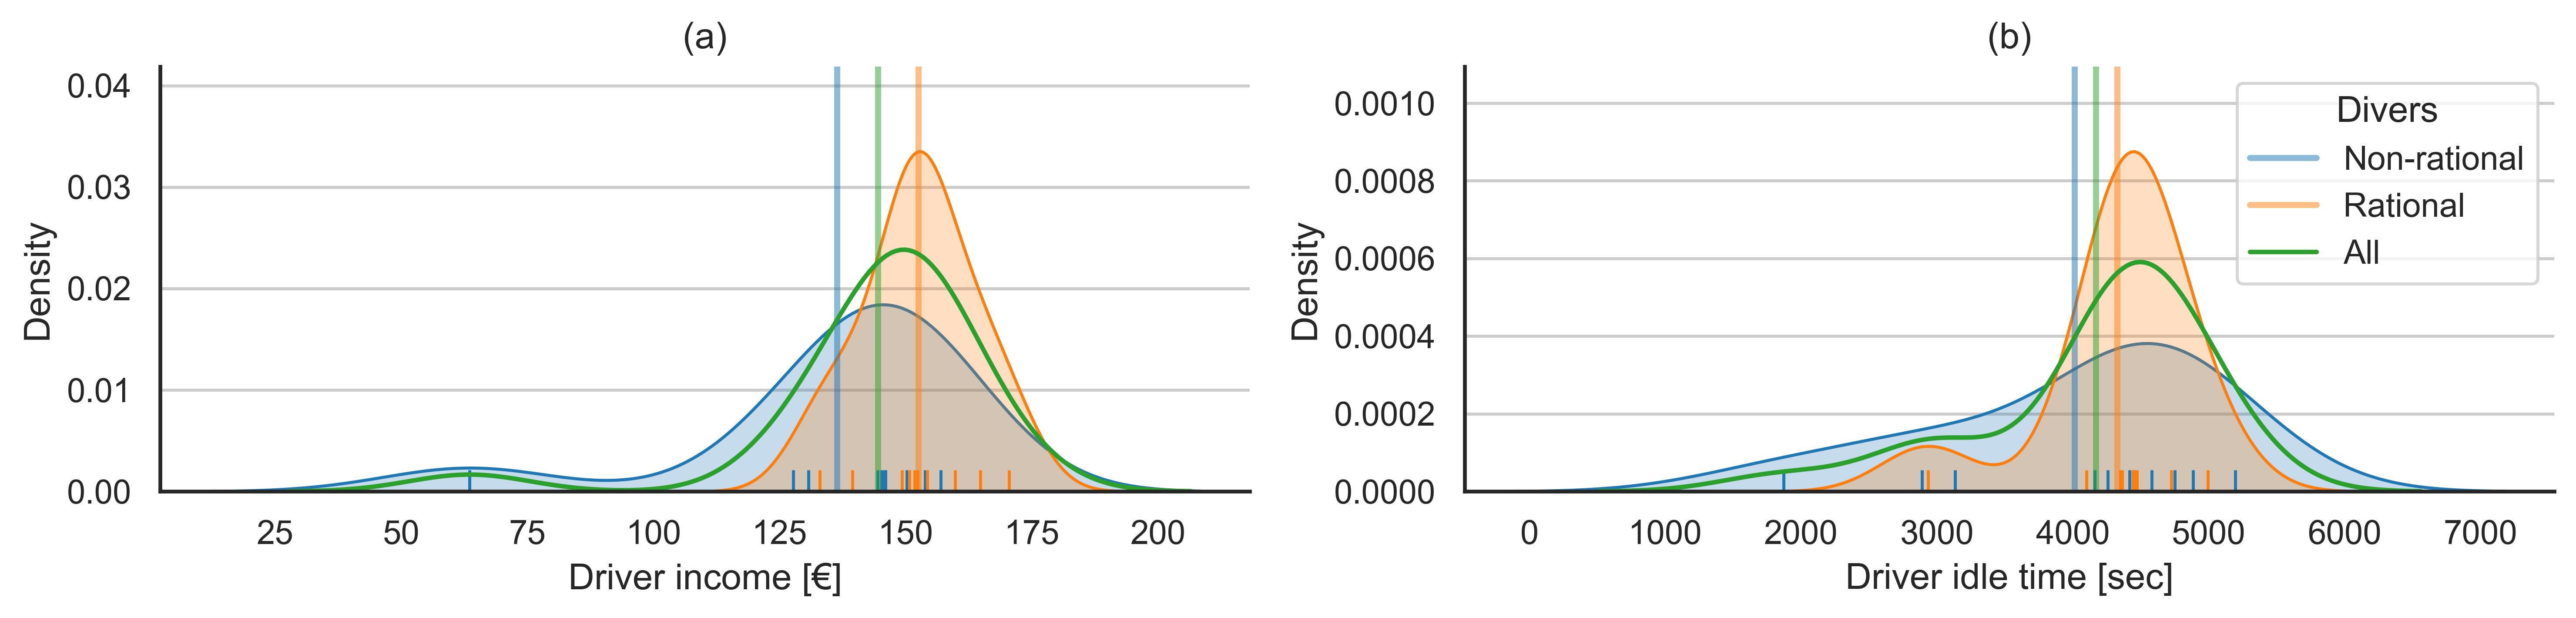

In [310]:
sns.set(rc={"figure.dpi":500, "savefig.dpi":500})
sns.set(font_scale = 1)
sns.set_palette('tab10')
sns.set_style('white')
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,3))
sns.despine()

sns.kdeplot(x = 'Driver income [€]', data=rra, ax = ax[0], shade=True)
sns.rugplot(x = 'Driver income [€]', data=rra, ax = ax[0], color='C0', height=0.05)
ax[0].axvline(x=rra['Driver income [€]'].mean(), linewidth=2, color='C0', label="mean", alpha=0.5)

sns.kdeplot(x = 'Driver income [€]', data=rrx, ax = ax[0], shade=True)
sns.rugplot(x = 'Driver income [€]', data=rrx, ax = ax[0], color='C1', height=0.05)
ax[0].axvline(x=rrx['Driver income [€]'].mean(), linewidth=2, color='C1', label="mean", alpha=0.5)

sns.kdeplot(x = 'Driver income [€]', data=rr, ax = ax[0], color='C2')
ax[0].axvline(x=rr['Driver income [€]'].mean(), linewidth=2, color='C2', label="mean", alpha=0.5)
ax[0].grid(axis='y')
ax[0].set_title('(a)')

# sns.kdeplot(x = 'waiting_t[sec]', data=rwa, ax = ax[1], shade=True)
# ax[1].axvline(x=rwa['waiting_t[sec]'].mean(), linewidth=2, color='C0', label="mean", alpha=0.5)

# sns.kdeplot(x = 'waiting_t[sec]', data=rwx, ax = ax[1], shade=True)
# ax[1].axvline(x=rwx['waiting_t[sec]'].mean(), linewidth=2, color='C1', label="mean", alpha=0.5)

# g = sns.kdeplot(x = 'waiting_t[sec]', data=rw, ax = ax[1], color='C2')
# ax[1].axvline(x=rw['waiting_t[sec]'].mean(), linewidth=2, color='C2', label="mean", alpha=0.5)
# g.legend(labels=["class a","class x","all drivers"], loc=2, fontsize = 15)


sns.kdeplot(x = "Driver idle time [sec]", data=rwda, ax = ax[1], shade=True)
sns.rugplot(x = "Driver idle time [sec]", data=rwda, ax = ax[1], color='C0', height=0.05)
ax[1].axvline(x=rwda["Driver idle time [sec]"].mean(), linewidth=2, color='C0', label="mean", alpha=0.5)

sns.kdeplot(x = "Driver idle time [sec]", data=rwdx, ax = ax[1], shade=True)
sns.rugplot(x = "Driver idle time [sec]", data=rwdx, ax = ax[1], color='C1', height=0.05)
ax[1].axvline(x=rwdx["Driver idle time [sec]"].mean(), linewidth=2, color='C1', label="mean", alpha=0.5)

sns.kdeplot(x = "Driver idle time [sec]", data=rwd, ax = ax[1], color='C2')
ax[1].axvline(x=rwd["Driver idle time [sec]"].mean(), linewidth=2, color='C2', label="mean", alpha=0.5)
ax[1].grid(axis='y')
ax[1].set_title('(b)')
ax[1].legend(title='Divers',labels=["Non-rational","Rational", "All"], loc=1)

plt.tight_layout()
plt.savefig('Fig4.png')

In [149]:
df = pd.DataFrame(d_f)
df['mean'] = df.mean(axis=1)
df

sim1        sim2        sim3        sim4        sim5        sim6  \
0 %           NaN         NaN         NaN         NaN         NaN         NaN   
10 %   142.070000  145.410000  146.560000  141.330000  144.360000  136.070000   
20 %   145.025000  142.475000  140.060000  151.135000  142.345000  144.650000   
30 %   137.746667  143.066667  147.310000  147.046667  144.513333  150.600000   
40 %   138.705000  144.745000  148.617500  146.005000  142.077500  141.515000   
50 %   144.464000  146.142000  142.886000  142.240000  144.462000  147.564000   
60 %   147.096667  142.991667  143.946667  141.571667  143.715000  142.120000   
70 %   143.470000  144.110000  144.138571  143.908571  140.965714  142.574286   
80 %   146.595000  144.885000  144.781250  145.445000  145.078750  144.288750   
90 %   144.534444  143.148889  143.437778  143.528889  144.401111  143.288889   
100 %  140.342000  140.622000  141.455000  141.002000  141.124000  141.075000   

             sim7        sim8        sim9       sim10        mean  
0 %           NaN         NaN         NaN         NaN         NaN  
10 %   144.290000  143.770000  136.030000  149.210000  142.910000  
20 %   148.830000  142.550000  150.110000  150.470000  145.765000  
30 %   137.056667  147.033333  149.746667  146.950000  145.107000  
40 %   146.312500  144.607500  142.837500  138.270000  143.369250  
50 %   143.108000  140.766000  143.242000  146.334000  144.120800  
60 %   140.570000  143.496667  145.431667  143.286667  143.422667  
70 %   140.901429  144.958571  142.922857  143.304286  143.125429  
80 %   144.166250  145.425000  143.325000  144.765000  144.875500  
90 %   144.763333  142.562222  141.307778  144.794444  143.576778  
100 %  141.138000  141.477000  141.124000  140.220000  140.957900

In [150]:
df['percentage'] = [i for i in np.arange(0,110,10)]
df

sim1        sim2        sim3        sim4        sim5        sim6  \
0 %           NaN         NaN         NaN         NaN         NaN         NaN   
10 %   142.070000  145.410000  146.560000  141.330000  144.360000  136.070000   
20 %   145.025000  142.475000  140.060000  151.135000  142.345000  144.650000   
30 %   137.746667  143.066667  147.310000  147.046667  144.513333  150.600000   
40 %   138.705000  144.745000  148.617500  146.005000  142.077500  141.515000   
50 %   144.464000  146.142000  142.886000  142.240000  144.462000  147.564000   
60 %   147.096667  142.991667  143.946667  141.571667  143.715000  142.120000   
70 %   143.470000  144.110000  144.138571  143.908571  140.965714  142.574286   
80 %   146.595000  144.885000  144.781250  145.445000  145.078750  144.288750   
90 %   144.534444  143.148889  143.437778  143.528889  144.401111  143.288889   
100 %  140.342000  140.622000  141.455000  141.002000  141.124000  141.075000   

             sim7        sim8        sim9       sim10        mean  percentage  
0 %           NaN         NaN         NaN         NaN         NaN           0  
10 %   144.290000  143.770000  136.030000  149.210000  142.910000          10  
20 %   148.830000  142.550000  150.110000  150.470000  145.765000          20  
30 %   137.056667  147.033333  149.746667  146.950000  145.107000          30  
40 %   146.312500  144.607500  142.837500  138.270000  143.369250          40  
50 %   143.108000  140.766000  143.242000  146.334000  144.120800          50  
60 %   140.570000  143.496667  145.431667  143.286667  143.422667          60  
70 %   140.901429  144.958571  142.922857  143.304286  143.125429          70  
80 %   144.166250  145.425000  143.325000  144.765000  144.875500          80  
90 %   144.763333  142.562222  141.307778  144.794444  143.576778          90  
100 %  141.138000  141.477000  141.124000  140.220000  140.957900         100

In [155]:
sns.set_style("whitegrid")

In [157]:
fig, ax = plt.subplots(figsize=(10,10))
sns.relplot(x='percentage', y='sim1', data=df, kind='line')
sns.regplot(x='total_bill', y='tip', data=tips)

AttributeError: 'AxesSubplot' object has no property 'figsize'

<Figure size 432x288 with 0 Axes>

In [160]:
tips = sns.load_dataset('tips')

(130.0, 160.0)

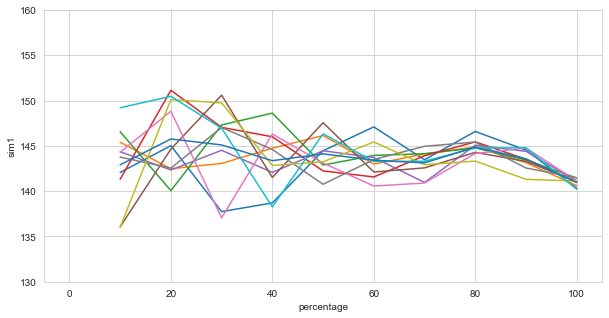

In [233]:
fig, ax = plt.subplots(figsize=(10,5))
for i in df.columns:
    plot = sns.lineplot(x='percentage', y=i, data=df)
    
plot.set_ylim(130,160)

(120.0, 160.0)

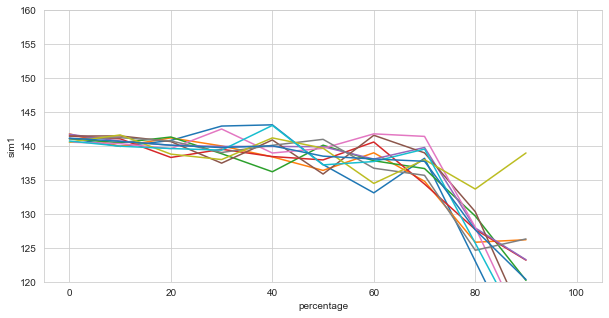

In [192]:
fig, ax = plt.subplots(figsize=(10,5))
for i in ds.columns:
    plot = sns.lineplot(x='percentage', y=i, data=ds)
    
plot.set_ylim(120,160)

In [190]:
ds = pd.DataFrame(d_s)
ds['mean'] = ds.mean(axis=1)
ds['percentage'] = [i for i in np.arange(0,110,10)]
ds

sim1        sim2        sim3        sim4        sim5        sim6  \
100 %  141.108000  141.770000  141.051000  141.461000  141.712000  141.453000   
90 %   139.933333  139.930000  140.463333  141.044444  140.707778  141.468889   
80 %   140.803750  141.180000  141.308750  138.298750  140.082500  140.636250   
70 %   142.920000  139.992857  138.852857  139.508571  139.925714  137.461429   
60 %   143.101667  138.385000  136.195000  138.431667  139.913333  140.873333   
50 %   137.252000  136.394000  140.104000  137.938000  139.882000  135.860000   
40 %   133.092500  138.987500  137.817500  140.572500  138.060000  141.562500   
30 %   138.180000  134.800000  136.666667  134.383333  139.766667  138.976667   
20 %   123.035000  125.825000  129.680000  127.705000  127.925000  130.320000   
10 %   107.850000  126.190000  120.210000  123.190000  123.240000  113.670000   
0 %           NaN         NaN         NaN         NaN         NaN         NaN   

             sim7        sim8        sim9       sim10        mean  percentage  
100 %  140.549000  141.043000  140.549000  140.720000  141.141600           0  
90 %   140.332222  141.204444  141.617778  139.954444  140.665667          10  
80 %   139.600000  140.730000  138.786250  139.612500  140.103875          20  
70 %   142.487143  139.028571  137.990000  139.375714  139.754286          30  
60 %   138.953333  140.090000  141.176667  143.011667  140.013167          40  
50 %   139.638000  140.966000  139.664000  137.206000  138.490400          50  
40 %   141.772500  136.715000  134.480000  137.697500  138.075750          60  
30 %   141.400000  135.670000  137.976667  139.530000  137.735000          70  
20 %   128.020000  124.640000  133.650000  125.690000  127.649000          80  
10 %   112.070000  126.310000  138.960000  111.650000  120.334000          90  
0 %           NaN         NaN         NaN         NaN         NaN         100

In [227]:
d_results['sim1p70'].passengers['waiting_t[sec]'].mean()

19.718

In [255]:
dw = {}

for i in range(1,11):
    d = {}
    for p in range(0,110,10):
        w = d_results['sim{sim_n}p{percentage}'.format(sim_n=i, percentage=p)].passengers['waiting_t[sec]'].mean()
        d["{} %".format(p)] = w
        
    dw["sim{}".format(i)] = d
        
       

In [256]:
dw = pd.DataFrame(dw)
dw['mean'] = dw.mean(axis=1)
dw['percentage'] = [i for i in np.arange(0,110,10)]
dw

sim1    sim2    sim3    sim4    sim5    sim6    sim7    sim8    sim9  \
0 %    19.432  20.408  17.964  20.704  18.504  20.814  21.748  23.582  23.358   
10 %   21.848  22.910  20.012  21.264  17.766  19.354  21.098  18.854  20.080   
20 %   20.884  18.694  20.128  21.462  19.320  18.250  17.632  20.560  20.286   
30 %   24.960  21.534  21.004  17.536  18.562  18.940  22.824  17.690  20.106   
40 %   25.324  20.018  22.070  20.174  20.396  18.938  20.842  24.388  19.502   
50 %   20.812  19.202  20.406  21.718  18.952  19.480  22.792  24.168  19.136   
60 %   20.082  24.434  18.486  21.210  17.472  18.782  23.252  19.662  19.194   
70 %   19.718  18.722  19.168  20.788  20.992  20.724  23.152  16.688  19.162   
80 %   17.700  19.152  22.180  24.032  18.624  18.514  20.454  20.888  20.512   
90 %   21.906  18.566  19.396  22.144  20.194  21.784  20.052  20.362  19.464   
100 %  21.114  21.716  17.980  18.206  19.738  19.186  20.756  20.630  20.462   

        sim10     mean  percentage  
0 %    20.420  20.6934           0  
10 %   20.376  20.3562          10  
20 %   19.668  19.6884          20  
30 %   20.870  20.4026          30  
40 %   20.974  21.2626          40  
50 %   18.362  20.5028          50  
60 %   21.972  20.4546          60  
70 %   16.880  19.5994          70  
80 %   19.834  20.1890          80  
90 %   23.956  20.7824          90  
100 %  20.242  20.0030         100

(0.0, 40.0)

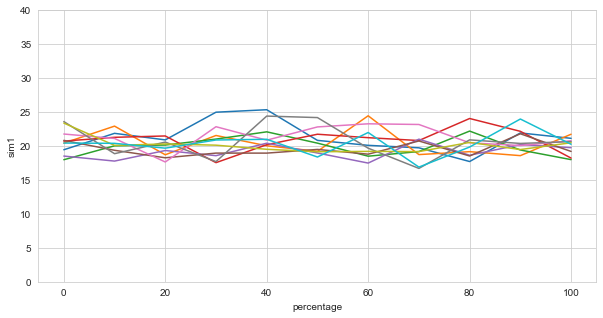

In [252]:
fig, ax = plt.subplots(figsize=(10,5))
a = list(dw.columns)
a.remove('percentage')

for i in a:
    plot = sns.lineplot(x='percentage', y=i, data=dw)
    
plot.set_ylim(0,40)

In [246]:
a = list(dw.columns)

In [249]:
a.remove('percentage')

In [250]:
a

['sim1',
 'sim2',
 'sim3',
 'sim4',
 'sim5',
 'sim6',
 'sim7',
 'sim8',
 'sim9',
 'sim10']

In [280]:
wf

pax_id  veh_id  waiting_t[sec]  number of declines
0         0     1.0             234                   0
1         1    20.0             197                   0
2         2    14.0              68                   0
3         3    17.0              86                   0
4         4     2.0             102                   0
..      ...     ...             ...                 ...
495     495     4.0             270                   0
496     496    20.0             114                   0
497     497    10.0             181                   0
498     498    11.0             250                   0
499     499    15.0             201                   0

[500 rows x 4 columns]

In [278]:
ws = d_results['sim10p0'].passengers
ds = d_results['sim10p0'].trips
ds

veh_id  pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
0        1       0       3.316667          1.99            3.983333    2.39   
1        1      19       0.650000          0.39            3.166667    1.90   
2        1      31       1.883333          1.13            4.000000    2.40   
3        1      46       3.183333          1.91            3.700000    2.22   
4        1      59       3.850000          2.31            4.900000    2.94   
..     ...     ...            ...           ...                 ...     ...   
20      20     408       5.216667          3.13            5.583333    3.35   
21      20     431       3.983333          2.39            1.916667    1.15   
22      20     452       3.933333          2.36            4.100000    2.46   
23      20     470       5.400000          3.24            4.483333    2.69   
24      20     487       6.083333          3.65            4.200000    2.52   

    travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $  p  sim  
0        7.800000          4.68                   0       4.78  0   10  
1        4.316667          2.59                  63       3.80  0   10  
2        6.383333          3.83                  15       4.80  0   10  
3        7.383333          4.43                  43       4.44  0   10  
4        9.250000          5.55                  10       5.88  0   10  
..            ...           ...                 ...        ... ..  ...  
20      11.300000          6.78                 106       6.70  0   10  
21       6.400000          3.84                  96       2.30  0   10  
22       8.533333          5.12                 239       4.92  0   10  
23      10.383333          6.23                 150       5.38  0   10  
24      10.783333          6.47                  13       5.04  0   10  

[500 rows x 12 columns]

In [279]:
wf = d_results['sim10p100'].passengers
df = d_results['sim10p100'].trips

<AxesSubplot:xlabel='pax_id', ylabel='waiting_t[sec]'>

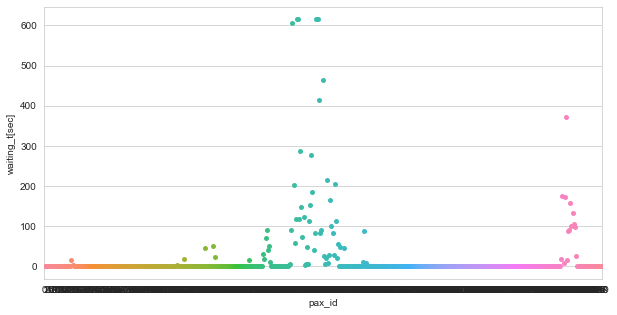

In [264]:
fig, ax = plt.subplots(figsize=(10,5))
sns.swarmplot(x='pax_id', y='waiting_t[sec]', data=ws)

<AxesSubplot:xlabel='pax_id', ylabel='waiting_t[sec]'>

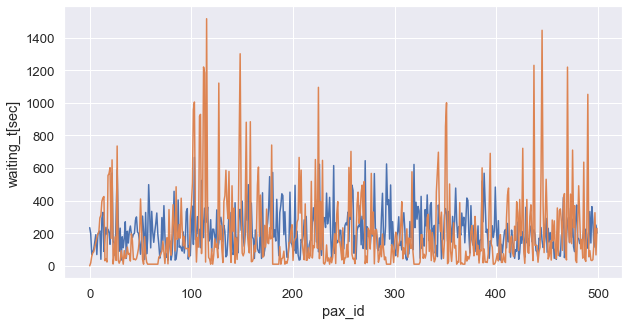

In [282]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='pax_id', y='waiting_t[sec]', data=wf)
sns.lineplot(x='pax_id', y='veh_waiting_t[sec]', data=df)

<AxesSubplot:xlabel='waiting_t[sec]', ylabel='Density'>

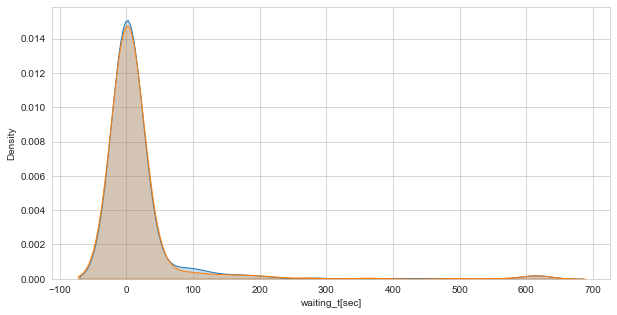

In [268]:
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(x='waiting_t[sec]', data=ws, shade=True)
sns.kdeplot(x='waiting_t[sec]', data=wf, shade=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.swarmplot(x='pax_id', y='waiting_t[sec]', data=ws)

In [273]:
d_results['sim10p100'].requests

veh_id  n_of_requests  n_of_accepted  n_of_declined  acceptance_rate %
0       1             32             24              8          75.000000
1       2             31             26              5          83.870968
2       3             32             24              8          75.000000
3       4             32             25              7          78.125000
4       5             25             20              5          80.000000
5       6             32             25              7          78.125000
6       7             39             29             10          74.358974
7       8             29             25              4          86.206897
8       9             28             24              4          85.714286
9      10             39             28             11          71.794872
10     11             31             26              5          83.870968
11     12             31             26              5          83.870968
12     13             38             27             11          71.052632
13     14             31             25              6          80.645161
14     15             35             28              7          80.000000
15     16             23             19              4          82.608696
16     17             28             25              3          89.285714
17     18             31             26              5          83.870968
18     19             25             21              4          84.000000
19     20             34             21             13          61.764706

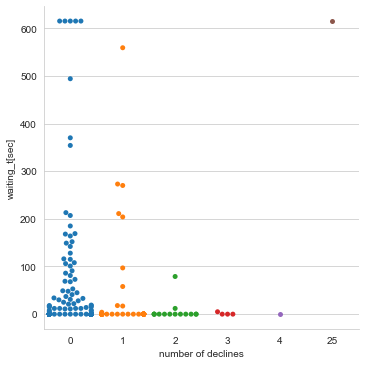

In [271]:
sns.catplot(x='number of declines', y='waiting_t[sec]', data=wf, kind='swarm')

(60.0, 100.0)

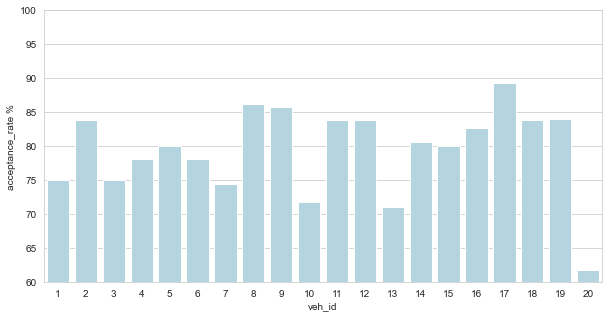

In [285]:
af = d_results['sim10p100'].requests

fig, ax = plt.subplots(figsize=(10,5))

g = sns.barplot(x='veh_id', y='acceptance_rate %', data=af, color='lightblue')
g.set_ylim(60,100)

<AxesSubplot:xlabel='acceptance_rate %', ylabel='revenue $'>

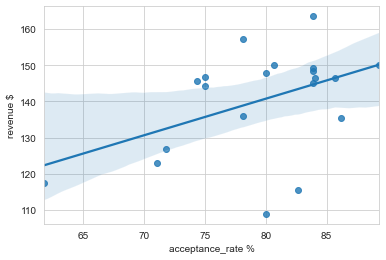

In [289]:
sns.regplot(x=d_results['sim10p100'].requests['acceptance_rate %'],
            y=d_results['sim10p100'].trips.groupby(['veh_id']).sum()['revenue $'])

In [198]:
df = df.join(fd['acceptance_rate %'])
df

veh_id  pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
0         1    6607      78.583333         47.15          136.683333   82.01   
1         2    5871      80.316667         48.19          111.950000   67.17   
2         3    5435      86.283333         51.77           97.800000   58.68   
3         4    7229      73.266667         43.96          123.933333   74.36   
4         5    6209      71.450000         42.87          106.583333   63.95   
..      ...     ...            ...           ...                 ...     ...   
195      16    6281      70.500000         42.30          122.050000   73.23   
196      17    5961      70.000000         42.00          119.883333   71.93   
197      18    5126      64.250000         38.55          125.366667   75.22   
198      19    5973      71.200000         42.72          109.066667   65.44   
199      20    6788      67.800000         40.68          145.000000   87.00   

     travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $  \
0       228.766667        137.26                3688     164.02   
1       204.933333        122.96                5170     134.34   
2       194.816667        116.89                6110     117.36   
3       210.700000        126.42                4675     148.72   
4       190.750000        114.45                5771     127.90   
..             ...           ...                 ...        ...   
195     204.550000        122.73                4925     146.46   
196     202.416667        121.45                5203     143.86   
197     201.466667        120.88                5261     150.44   
198     192.266667        115.36                5758     130.88   
199     226.900000        136.14                3898     174.00   

     acceptance_rate %  
0            79.411765  
1            83.333333  
2            60.000000  
3            84.375000  
4            71.428571  
..                 ...  
195          72.727273  
196          75.757576  
197          76.666667  
198          68.571429  
199          77.777778  

[200 rows x 11 columns]

In [213]:
s1 = df[df['acceptance_rate %']>65]; s1 = df[df['acceptance_rate %']<80]
s1

veh_id  pax_id  pickup_t[min]  pickup_d[km]  travel_t_with[min]  pax_km  \
0         1    6607      78.583333         47.15          136.683333   82.01   
2         3    5435      86.283333         51.77           97.800000   58.68   
4         5    6209      71.450000         42.87          106.583333   63.95   
5         6    5862      72.316667         43.39          133.300000   79.98   
6         7    5819      79.866667         47.92          117.883333   70.73   
..      ...     ...            ...           ...                 ...     ...   
195      16    6281      70.500000         42.30          122.050000   73.23   
196      17    5961      70.000000         42.00          119.883333   71.93   
197      18    5126      64.250000         38.55          125.366667   75.22   
198      19    5973      71.200000         42.72          109.066667   65.44   
199      20    6788      67.800000         40.68          145.000000   87.00   

     travel_t[min]  travel_d[km]  veh_waiting_t[sec]  revenue $  \
0       228.766667        137.26                3688     164.02   
2       194.816667        116.89                6110     117.36   
4       190.750000        114.45                5771     127.90   
5       217.116667        130.27                4316     159.96   
6       209.750000        125.85                5232     141.46   
..             ...           ...                 ...        ...   
195     204.550000        122.73                4925     146.46   
196     202.416667        121.45                5203     143.86   
197     201.466667        120.88                5261     150.44   
198     192.266667        115.36                5758     130.88   
199     226.900000        136.14                3898     174.00   

     acceptance_rate %  
0            79.411765  
2            60.000000  
4            71.428571  
5            71.875000  
6            77.419355  
..                 ...  
195          72.727273  
196          75.757576  
197          76.666667  
198          68.571429  
199          77.777778  

[154 rows x 11 columns]

<AxesSubplot:xlabel='acceptance_rate %', ylabel='revenue $'>

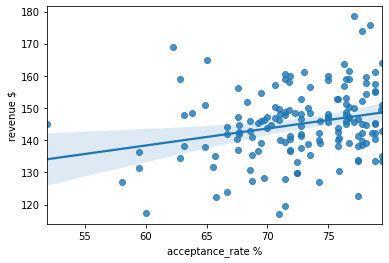

In [214]:
sns.regplot(x=s1['acceptance_rate %'], y=s1['revenue $'])

In [ ]:
first_half = r_5050.trips.groupby(['veh_id']).sum().iloc[0:int(params.nV*p/100)].sum()['revenue $']/int(params.nV*p/100)
second_half = r_5050.trips.groupby(['veh_id']).sum().iloc[int(params.nV*p/100):int(params.nV)].sum()['revenue $']/int(round(params.nV*(1-p/100)))      
df["{} %".format(p)] = first_half
ds["{} %".format(100-p)] = second_half

d_f["sim{}".format(i)] = df
d_s["sim{}".format(i)] = ds
